$$ \Large{IMA205 \space Challenge \space 2023:  \space Cardiac \space Pathology \space Prediction} $$

<h1><center> Souheib Ben Mabrouk</center></h1>

# Plan

1. Introduction
2. Importing libraries
3. Importing and exploring the data
4. Metrics
5. Segmentation of the left ventricle cavity
6. Feature extraction
7. Methods over extracted features 
8. Conclusion
9. References

# 1. Introduction

This 2023 IMA205 course challenge is centered around four heart conditions that are initially asymptomatic, but can potentially lead to life-threatening complications such as severe heart failure and sudden cardiac arrest. Early identification of these conditions is crucial in order to provide timely treatment and prevent further complications. To achieve this, various approaches for automatic diagnosis using cardiac magnetic resonance imaging (CMRI) have been proposed.

More particularly, the aim is to classify MRI images of the heart into five diagnostic classes: 

* ‘0’ Healthy controls 
* ‘1’Myocardial infarction 
* ‘2’ Dilated cardiomyopathy 
* ‘3’ Hypertrophic cardiomyopathy 
* ‘4’ Abnormal right ventricle. 

To do so, we will use a dataset of 150 subjects with their MRI images and, when available, their corresponding segmentations and metadata (subject height and weight). Our goal is to establish an accurate classification in order to provide appropriate treatment and improve patient outcomes.


# 2. Importing libraries

In [ ]:
##Libraries for data processing
import numpy as np
import nibabel as nib  # for reading and writing NIfTI images                                                                                                       
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from scipy import ndimage
import time
from skimage.segmentation import find_boundaries
from google.colab import files
from google.colab import drive # module to mount Google Drive

##Libraries for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

##Libraries for deep learning (Optional) part
from tensorflow.keras.applications import ResNet50V2
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import  EarlyStopping
from tensorflow.keras.metrics import MeanIoU

#Ignore ConvergenceWarning while tuning the hyperparameters
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#Confugration for visualization 
%matplotlib inline
sns.reset_defaults()
sns.set_theme(style="darkgrid")
sns.set(palette='colorblind')

# Versions
print("I used the version 2.12.0 of tf.keras and the version 3.0.2 of nibabel")

print("You are using the version",tf.keras.__version__," of tf.keras ")
print("You are using the version",nib.__version__," of nibabel ")

I used the version 2.12.0 of tf.keras and the version 3.0.2 of nibabel
You are using the version 2.12.0  of tf.keras 
You are using the version 3.0.2  of nibabel 


### Useful functions

**report_best_scores**: For hyperparameters selection

In [ ]:
def report_best_scores(results, n_top=3):
    """
    Report the best scores and associated hyperparameters of a trained machine learning model.
    
    Parameters:
    -----------
    results: dict
        A dictionary containing the results of a `GridSearchCV` function.
        It should contain the following keys: 'mean_test_score', 'std_test_score', 'rank_test_score', and 'params'.
    n_top: int, optional
        The number of top-performing models to report. Default is 3.
    
    Output:
    -------
    Prints the mean validation score, standard deviation, and the corresponding hyperparameters for each of the 
    top-performing models in the search results.
    """

    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

**Boxplot:** To deal with outliers

In [ ]:
def distbox(data,feature):
  """
   A function to plot the distribution and box plot of a feature
  """
  fig, axes = plt.subplots(1, 2, figsize=(20, 6))

  ax1 = sns.histplot(data[feature],ax=axes[0],kde=True,bins=30)
  ax2 = sns.boxplot(data[feature],ax=axes[1])
  plt.show()
  return

**Contlabel:** For data visualisation and understanding

In [ ]:
def countlabel(data,feature, values):
  """
    Plots a countplot of the given feature in the provided data, showing the count of each value of the feature in the "Category" column.
  """
  plt.figure(figsize=(10,5))
  ax = sns.countplot(data = data, x = feature, hue="Category", palette = 'rocket')
  plt.xlabel(feature, fontsize= 12)
  plt.ylabel("Count", fontsize= 12)
  plt.ylim(0,6000)
  plt.xticks([*range(len(values))],values, fontsize = 11)
  for p in ax.patches:
      ax.annotate((p.get_height()), (p.get_x()+0.16, p.get_height()+1000))

  plt.show()
  return

#3. Importing and exploring the data

## 3.1 Loading data

In [ ]:
# Checking if the code is running on Google Colab environment

if 'google.colab' in str(get_ipython()):
  # Mounting Google Drive to the Colab environment to access files
  drive.mount('/content/drive')

  # Setting the paths to the train and test directories
  #If you are using Colab, make sure it is linked to your drive and that you have uploaded the folder Challenge_IMA205 to drive
  train_path='/content/drive/MyDrive/Challenge_IMA205/Train/'
  test_path='/content/drive/MyDrive/Challenge_IMA205/Test/'

  # Setting the paths to the metadata files for the train and test sets
  metaDataTrain_path='/content/drive/MyDrive/Challenge_IMA205/metaDataTrain.csv'
  metaDataTest_path='/content/drive/MyDrive/Challenge_IMA205/metaDataTest.csv'

else:
  print('You are not using Colab. Please define the absolute paths to the folder where you downloaded the data')



Mounted at /content/drive


In [ ]:
# Reading the metadata file for the train set into a pandas DataFrame
pd_train = pd.read_csv(metaDataTrain_path)

# Reading the metadata file for the test set into a pandas DataFrame
pd_test = pd.read_csv(metaDataTest_path)

standard_shape=(256,256) #standard shape used to resize the images


## 3.2. Preprocessing and Visualizing the data

**Preprocess_image**: Resize the image to the standard shape, then normalize and standardize the intensity at each slice.

PS: The normalization of the third dimension (number of channels) poses a challenge, since the number of channels varies between the images, ranging from six to more than 15 channels. In order to avoid losing information during the normalization process, the number of channels of the original image will be preserved, and the mean will be taken over the channels when required. 

In [ ]:
def preprocess_image(img):
    # Resize the image to a fixed size of (256, 256) while maintaining the original number of channels.
    img_resized = cv2.resize(img, standard_shape, interpolation=cv2.INTER_CUBIC) / 255.0

    # Calculate the mean intensity value across all channels for each slice and subtract it from the slice.
    # This centers the intensity values around 0 and makes the distribution of intensity values more similar across slices.
    for i in range(img_resized.shape[-1]):
        mean_intensity = np.mean(img_resized[:,:,i])
        img_resized[:,:,i] -= mean_intensity
    
    # Divide each slice by its standard deviation to scale the intensity values between -1 and 1.
    # This ensures that the intensity values have the same range across slices and makes the data more suitable for training.
    for i in range(img_resized.shape[-1]):
        std_intensity = np.std(img_resized[:,:,i])
        img_resized[:,:,i] /= std_intensity
        
    return img_resized

**Visualize_data_image :** Visualize a given channel of the medical images ES and ED and their corresponding segmentations.

In [ ]:
def visualize_data_image(image_ID,channel=1): 

  """
    Visualize medical images and their corresponding segmentations.
    This function is intended for visualization purposes only and returns nothing.

    Parameters:
    -----------
    image_ID : int
        An integer identifying the image to be visualized.
    channel : int
        An integer identifying the channel of image to be visualized (default = 1).

    Returns:
    --------
    None. The function returns nothing, as it is intended only for visualization purposes.
  """

  # Setting the file paths to the input images and their corresponding segmentations
  path_image_ED=train_path+str(image_ID)+ "/"+str(image_ID)+"_ED.nii"
  path_image_ED_seg=train_path+str(image_ID)+ "/"+str(image_ID)+"_ED_seg.nii"
  path_image_ES=train_path+str(image_ID)+ "/"+str(image_ID)+"_ES.nii"
  path_image_ES_seg=train_path+str(image_ID)+ "/"+str(image_ID)+"_ES_seg.nii"

  # Loading the input images and their corresponding segmentations 
  image_ED=nib.load(path_image_ED)
  image_ED = image_ED.get_fdata()
  image_ED_seg=nib.load(path_image_ED_seg)
  zooms_ED = image_ED_seg.header.get_zooms() # Get the voxel size of the image
  v_ED = np.prod(zooms_ED)  
  image_ED_seg = image_ED_seg.get_fdata()

  image_ES=nib.load(path_image_ES)
  image_ES = image_ES.get_fdata()

  image_ES_seg=nib.load(path_image_ES_seg)
  zooms_ES = image_ES_seg.header.get_zooms()  # Get the voxel size of the image
  v_ES = np.prod(zooms_ES) 
  image_ES_seg = image_ES_seg.get_fdata()

  # Combining the images into a list
  images=[image_ED,image_ED_seg,image_ES,image_ES_seg]

  # Displaying the images and their corresponding segmentations
  for image in images:
    image = preprocess_image(image)
    height, width, depth = image.shape
    print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")
    i=channel
    plt.figure()
    print(f"Plotting Layer {i} of Image")
    plt.imshow(image[:, :, i], cmap='gray')
    plt.axis('off')
    plt.show()
  return


**visualize_slices:** Visualizes all the slices of a cardiac MRI image and their segmentations.

In [ ]:
def visualize_slices(image_ID,state):

  """
    Visualizes the slices of a cardiac MRI image and its segmentation mask.

    Args:
    image_ID (int): ID of the MRI image.
    state (str): State of the cardiac cycle, either "ES" (end-systole) or "ED" (end-diastole).

    Returns:
    None. The function returns nothing, as it is intended only for visualization purposes.
    """

  if state == "ED":
    path_image_ED=train_path+str(image_ID)+ "/"+str(image_ID)+"_ED.nii"
    path_image_ED_seg=train_path+str(image_ID)+ "/"+str(image_ID)+"_ED_seg.nii"
    image_ED=nib.load(path_image_ED)
    img = image_ED.get_fdata()
    img = preprocess_image(img)
    image_ED_seg=nib.load(path_image_ED_seg)  
    img_seg = image_ED_seg.get_fdata()

  elif state == "ES":
    path_image_ES=train_path+str(image_ID)+ "/"+str(image_ID)+"_ES.nii"
    path_image_ES_seg=train_path+str(image_ID)+ "/"+str(image_ID)+"_ES_seg.nii"
    image_ES=nib.load(path_image_ES)
    img = image_ES.get_fdata()
    img = preprocess_image(img)
    image_ES_seg=nib.load(path_image_ES_seg)
    img_seg = image_ES_seg.get_fdata()

  else: 
    print("state should be ES or ED")
    return
  depth=img.shape[2]
  print(f"The image object has {depth} channels")
  plt.figure(figsize=(15, 5))
  for idx in range (depth):
      plt.subplot(2, depth//2, idx+1)
      ima = img[:,:,idx]
      plt.imshow(ima,cmap="gray")
      plt.axis('off')
      plt.title("slice n° " + str(idx+1))
  plt.show()
  print("")
  print("The segmentation of each slice")
  plt.figure(figsize=(15, 5))
  for idx in range (depth):
      plt.subplot(2, 5, idx+1)
      ima = img_seg[:,:,idx]
      plt.imshow(ima,cmap="gray")
      plt.axis('off')
      plt.title("slice n° " + str(idx+1))
  plt.show()

The image object has the following dimensions: height: 256, width:256, depth:10
Plotting Layer 1 of Image


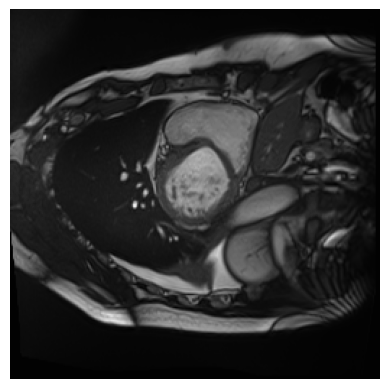

<ipython-input-37-a03d8b90d8d2>:15: RuntimeWarning: invalid value encountered in true_divide
  img_resized[:,:,i] /= std_intensity


The image object has the following dimensions: height: 256, width:256, depth:10
Plotting Layer 1 of Image


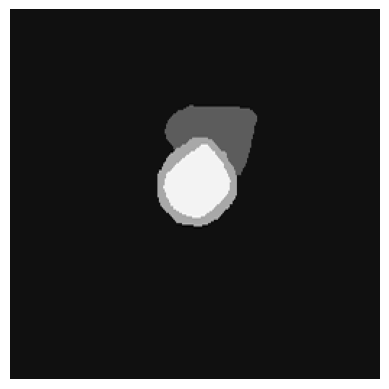

The image object has the following dimensions: height: 256, width:256, depth:10
Plotting Layer 1 of Image


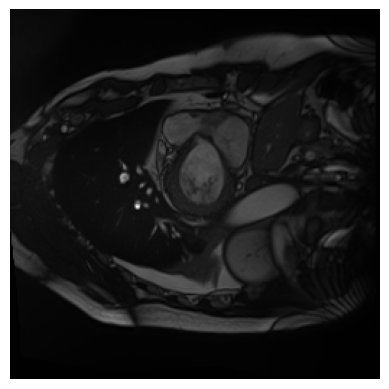

The image object has the following dimensions: height: 256, width:256, depth:10
Plotting Layer 1 of Image


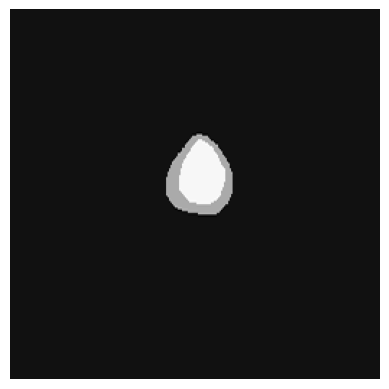

In [ ]:
visualize_data_image("001",channel=1)

The image object has 10 channels


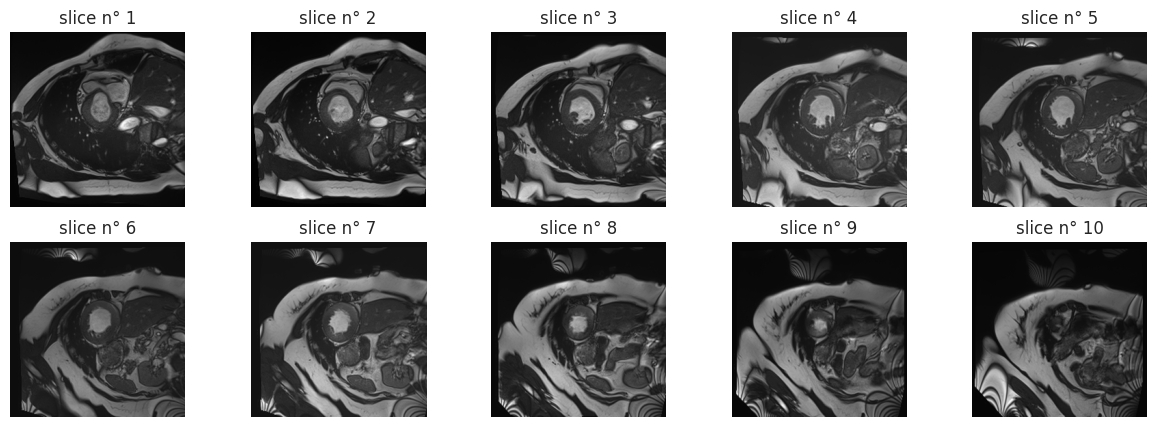


The segmentation of each slice


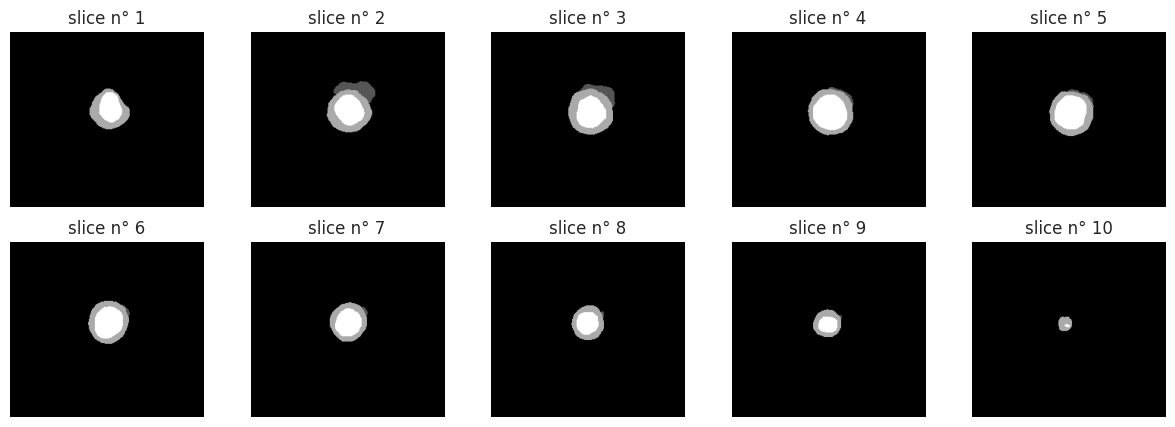

In [ ]:
visualize_slices("002","ES")

## 3.3 Exploring the data : Create a class of subjects

* I represented the individuals with a super class "Subject". Each subject has the attributes corresponding to his metadata and MRI images. 
* 2 subclasses of subjects are created subject_train which we know its diagnostic class and subject_test which we aim to predict its diagnostic class among the 5 classes.

In [ ]:
class Subject:
  def __init__(self, image_ED, image_ED_seg,image_ES,image_ES_seg,height,weight,id,v_ED,v_ES):
    """
    A class representing a subject with their corresponding metadata , input images and segmentations at End-Diastole (ED) and End-Systole (ES).

    Args:
      image_ED (numpy.ndarray): Input image at ED.
      image_ED_seg (numpy.ndarray): Corresponding segmentation of the input image at ED.
      image_ES (numpy.ndarray): Input image at ES.
      image_ES_seg (numpy.ndarray): Corresponding segmentation of the input image at ES.
      height (float): The height of the subject.
      weight (float): The weight of the subject.
      id (int): The ID number of the subject.
      v_ED (float): The voxel volume at ED.
      v_ES (float): The voxel volume at ES.
    """

    self.image_ED = image_ED,
    self.image_ED_seg = image_ED_seg,
    self.image_ES = image_ES,
    self.image_ES_seg = image_ES_seg,
    self.height = height,
    self.weight = weight,
    self.id=id
    self.v_ED=v_ED
    self.v_ES=v_ES


class Subject_train(Subject):
  """
  Subclass of Subject, that has a known label corresponding to the diagnostic class, and will be used for train
  """
  def __init__(self, image_ED, image_ED_seg,image_ES,image_ES_seg,height,weight,id,v_ED,v_ES,label):
    super().__init__(image_ED, image_ED_seg,image_ES,image_ES_seg,height,weight,id,v_ED,v_ES),
    self.label = label


  def __plot__(self,channel):
    """
    A method to plot a specific slice of the input images at ED and ES.
    Args:
      channel (int): The slice to be plotted.
    Returns:
      None
    """
    images=[self.image_ED,self.image_ED_seg,self.image_ES,self.image_ES_seg]
    for image in images:
      plt.figure()
      print(f"Plotting Layer {channel} of Image")
      plt.imshow(image[:, :, channel], cmap='gray')


class Subject_test(Subject):
  def __init__(self, image_ED, image_ED_seg,image_ES,image_ES_seg,height,weight,id,v_ED,v_ES):
    """
    Subclass of Subject, has no known label, and will be used for test 
    """

    super().__init__(image_ED, image_ED_seg,image_ES,image_ES_seg,height,weight,id,v_ED,v_ES)

  def __plot__(self,channel):
    """
    A method to plot a specific slice of the input images at ED and ES.
    Args:
      channel (int): The slice to be plotted.
    Returns:
      None
    """
    images=[self.image_ED,self.image_ED_seg,self.image_ES,self.image_ES_seg]
    for image in images:
      plt.figure()
      print(f"Plotting Layer {channel} of Image")
      plt.imshow(image[:, :, channel], cmap='gray')
    

In [ ]:
def make_Subject_train(image_ID):
  """
    Load and preprocess training data for a given image ID, and construct a Subject_train object.

    Args:
        image_ID (int): The ID of the image to load.

    Returns:
        A Subject_train object containing the preprocessed image data and metadata.
  """

  #make paths for the 4 images
  path_image_ED=train_path+str(image_ID)+ "/"+str(image_ID)+"_ED.nii"
  path_image_ED_seg=train_path+str(image_ID)+ "/"+str(image_ID)+"_ED_seg.nii"
  path_image_ES=train_path+str(image_ID)+ "/"+str(image_ID)+"_ES.nii"
  path_image_ES_seg=train_path+str(image_ID)+ "/"+str(image_ID)+"_ES_seg.nii"

  #load the images and resize

  image_ED=nib.load(path_image_ED)
  image_ED = image_ED.get_fdata()
  image_ED=preprocess_image(image_ED)

  image_ED_seg=nib.load(path_image_ED_seg)
  zooms_ED = image_ED_seg.header.get_zooms()
  v_ED = np.prod(zooms_ED) 
  image_ED_seg = image_ED_seg.get_fdata()
  image_ED_seg=cv2.resize(image_ED_seg, standard_shape, interpolation=cv2.INTER_CUBIC) 

  image_ES=nib.load(path_image_ES)
  image_ES = image_ES.get_fdata()
  image_ES=preprocess_image(image_ES)

  image_ES_seg=nib.load(path_image_ES_seg)
  zooms_ES = image_ES_seg.header.get_zooms()
  v_ES = np.prod(zooms_ES) 
  image_ES_seg = image_ES_seg.get_fdata()
  image_ES_seg=cv2.resize(image_ES_seg, standard_shape, interpolation=cv2.INTER_CUBIC) 


  #extact the id and the features
  id=int(image_ID)
  label=pd_train['Category'][id-1]
  height=pd_train['Height'][id-1]
  weight=pd_train['Weight'][id-1]

  #construct the subject
  subject = Subject_train(
    id=image_ID,
    image_ED = image_ED,
    image_ED_seg = image_ED_seg,
    image_ES = image_ES,
    image_ES_seg = image_ES_seg,
    height = height,
    weight = weight,
    v_ED = v_ED,
    v_ES = v_ES,
    label = label)
  
  return(subject)



In [ ]:
def make_Subject_test(image_ID):
  """
    Load and preprocess test data for a given image ID, and construct a Subject_test object.

    Args:
        image_ID (int): The ID of the image to load.

    Returns:
        A Subject_test object containing the preprocessed image data and metadata.
  """

  # make paths for the 4 images
  path_image_ED=test_path+str(image_ID)+ "/"+str(image_ID)+"_ED.nii"
  path_image_ED_seg=test_path+str(image_ID)+ "/"+str(image_ID)+"_ED_seg.nii"
  path_image_ES=test_path+str(image_ID)+ "/"+str(image_ID)+"_ES.nii"
  path_image_ES_seg=test_path+str(image_ID)+ "/"+str(image_ID)+"_ES_seg.nii"

  #  load the images and resize
  image_ED=nib.load(path_image_ED)
  image_ED = image_ED.get_fdata()
  image_ED=preprocess_image(image_ED)

  image_ED_seg=nib.load(path_image_ED_seg)
  zooms_ED = image_ED_seg.header.get_zooms()
  v_ED = np.prod(zooms_ED) 
  image_ED_seg = image_ED_seg.get_fdata()
  image_ED_seg=cv2.resize(image_ED_seg, standard_shape, interpolation=cv2.INTER_CUBIC) 

  image_ES=nib.load(path_image_ES)
  image_ES = image_ES.get_fdata()
  image_ES=preprocess_image(image_ES)

  image_ES_seg=nib.load(path_image_ES_seg)
  zooms_ES = image_ES_seg.header.get_zooms()
  v_ES = np.prod(zooms_ES) 
  image_ES_seg = image_ES_seg.get_fdata()
  image_ES_seg=cv2.resize(image_ES_seg, standard_shape, interpolation=cv2.INTER_CUBIC) 
  
  #extact the id and the features
  id=int(image_ID)
  height=pd_test['Height'][id-101]
  weight=pd_test['Weight'][id-101]

  #construct the subject
  subject = Subject_test(
    id=image_ID,
    image_ED=image_ED,
    image_ED_seg=image_ED_seg,
    image_ES=image_ES,
    image_ES_seg=image_ES_seg,
    height=height,
    weight=weight,
    v_ED = v_ED,
    v_ES = v_ES,)
    

  return(subject)

## 3.4 Exploring the data : Generate the datasets

In [ ]:
# Buliding the dataset of subjects, (may take a while to run)

train_list=[]
test_list=[]
train_ids=[str(i).zfill(3) for i in range(1,101)] 
test_ids=[str(i).zfill(3) for i in range(101,151)]
for image_ID in train_ids:
  subject=make_Subject_train(image_ID)
  train_list.append(subject)

for image_ID in test_ids:
  subject=make_Subject_test(image_ID)
  test_list.append(subject)


In [ ]:
#check the size of the data
print('Training dataset size:', len(train_list), 'subjects')
print('Testing dataset size:', len(test_list), 'subjects')

Training dataset size: 100 subjects
Testing dataset size: 50 subjects


## 3.5. Distribution of datapoints 

At last, we will take a look at how is the frequency of examples in our dataset, for each individual category. This is important as if we apply a machine learning method over a very unbalanced dataset, the tendency will be that it will classify the least frequent class as the most frequent class. So we need to verify the data balance and the distributions of the metadata features to deal with outliers and imputations. 

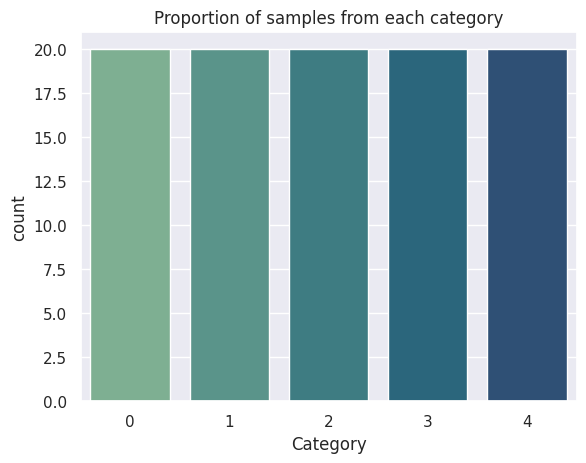

In [ ]:
id = pd_train["Id"].to_numpy()
category = pd_train["Category"].to_numpy()
height = pd_train["Height"].to_numpy()
weight = pd_train["Weight"].to_numpy()

ax = sns.countplot(x="Category", data=pd_train,palette="crest")
plt.title('Proportion of samples from each category')
plt.show()

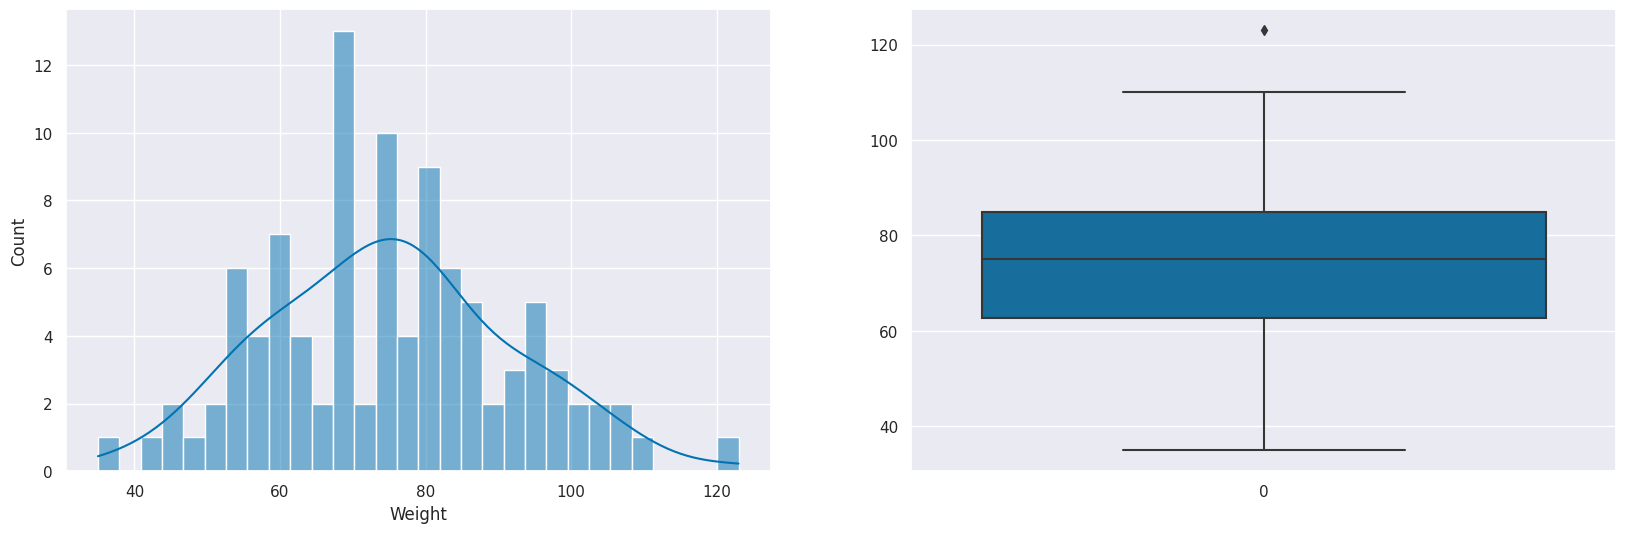

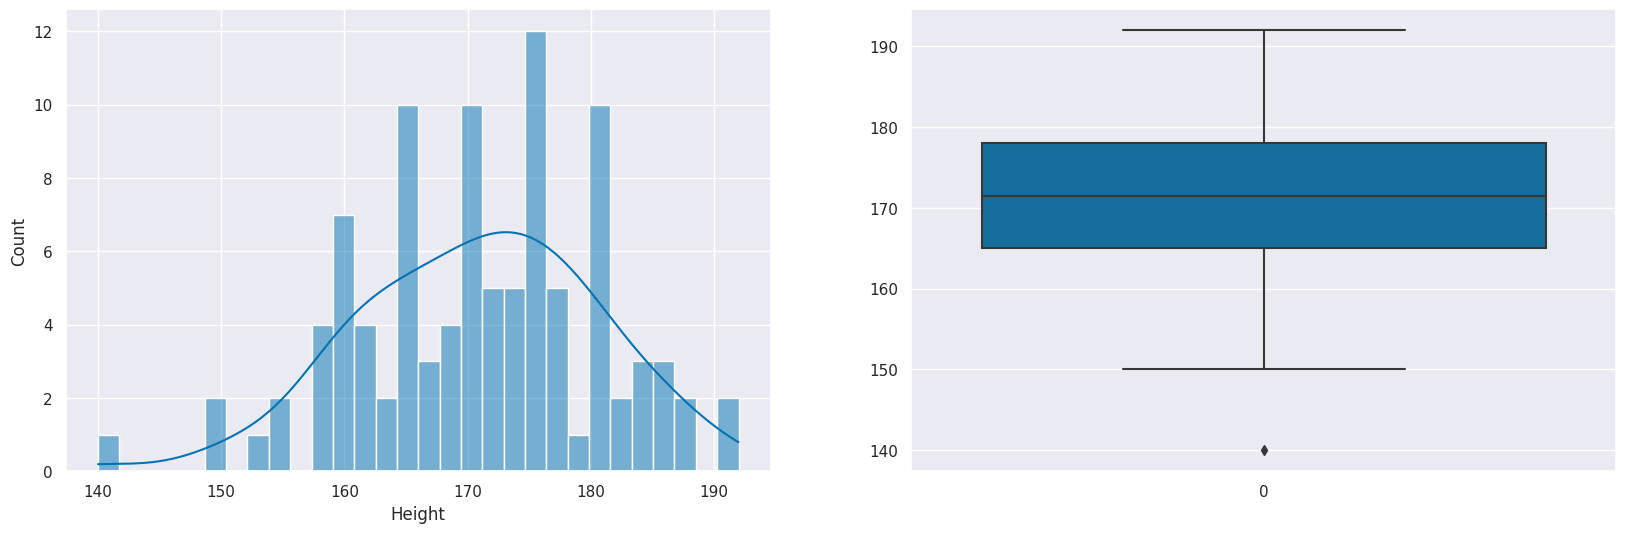

In [ ]:
distbox(pd_train,"Weight")
distbox(pd_train,"Height")

<blockquote>

* We can remark that we are in the case of a balanced data since we have 20 subjects for each class in the training datasets. 
* The distributions of the weight and height for the training data sets seems to be good, it could be approximated to normal distribution and there is no strange effect of outliers within the data. 
* A better data understanding will be done later while the feature extraction.



# 4. Metrics

As ranking metric, we will use the Categorization Accuracy, which is defined as:
$$ Acc = \frac{1}{N} \sum_{i=1}^{N} I(y_i=f_i) $$

where $N = 50$ is the number of test subjects , $y_i$ the ground truth label for subject $i$, and $f_i$ the predicted label.

In [ ]:
def categorization_accuracy(y_true, y_pred):
    """
    Computes the Categorization Accuracy metric.

    Args:
    - y_true (list): list of true labels for each test subject.
    - y_pred (list): list of predicted labels for each test subject.

    Returns:
    - accuracy (float): Categorization Accuracy score.
    """
    n = len(y_true)
    correct = sum([1 if y_true[i] == y_pred[i] else 0 for i in range(n)])
    accuracy = correct / n

    return accuracy


# 5. Segmentation of the left ventricle cavity

## 5.1 Segmentation by filling method (inspired from the given segmentation)




The objective of this part is to segment the left ventricle cavity of the heart for the test subjects because we only have partial segmentations. To do so, I tried to take advantage of the given segmentation and add a recursive method to extract the left ventricle using some assumptions on the data.

**Assumption:** the left ventricle cavity is a connex form in the image that is surrounded by the Myocardium and that is not related directly to the background.

**check_image:** Preprocess the segmentation image using Thresholds to produce a trinary image with the values {0,1,2}. In other words, check the given segmentation and make sure it only contains 3 labels as the following:

* 0: Background (and left ventricle for now) 
* 1: Right ventricle cavity 
* 2: Myocardium

In [ ]:
def check_image(img):
  """
    Thresholds the input image array to produce a trinary image.

    Args:
        img (numpy.ndarray): A 2D array representing an image. The dimensions
            of the array should be (height, width).

    Returns:
        numpy.ndarray: A copy of the input image array after applying thresholding. The output
            image array has the same dimensions and data type as the input image array. The
            pixel values of the output image are set to 0, 1, or 2 corresponding to the mask of the test image.
    """

  for j in range (img.shape[1]):
   for i in range (img.shape[0]):
    
      if img[i,j]<0.5: 
        img[i,j]=0
      elif img[i,j]<1.5: 
        img[i,j]=1
      else: 
        img[i,j]=2
  return(img.copy())

**starting_point**: The aim of this function is to find a point inside the left ventricle cavity based on the given partial segmentation of the image. This point can be found once we are inside the Myocardium and we find a pixel classified as background (value=0).


In [ ]:
def starting_point(img):
  """
    Finds the starting point inside the left ventricle cavity in the input image array.

    Args:
        img (numpy.ndarray): A 2D NumPy array representing an image. 

    Returns:
        tuple: A tuple of integers representing the coordinates of the starting point 
             in the input image. If a suitable starting point is found, the 
            function returns the coordinates of the pixel inside the left ventricle. 
            If no suitable starting point is found,the function returns the default starting point of (0, 0).
  """

  start_point=(0,0)
  for i in range (img.shape[0]):
    for j in range (img.shape[1]-1):
      if img[i][j]>1.5 and img[i][j+1]<0.5 and img[i,j-1]>1.5:
        start_point=(i,j+1)
        break
  return(start_point)

**PS:** The dual problem would be to find a point in the background (typically (0,0)), then, label the background and then extact the left ventricle cavity as the area that is not attached to the background and have the label = 0

In [ ]:
def find_start_point(img):
  """
    The dual problem would be to find a point in the background (typically (0,0)), 
    label the background and then extact the left ventricle cavity as the area that 
    is not attached to the background
  """

  #start_point=(0,0)
  #for i in range (img.shape[0]):
    #for j in range (img.shape[1]-1):
      #if img[i][j]>1.5 and img[i][j+1]<0.5 and img[i,j-1]>1.5:
        #start_point=(i,j+1)
        #break
  #return(start_point)
  return((0,0))

**fill_region** Fills all the connected regions with pixel value 0 by 3 starting from the given pixel position (x,y)  in the given 2D matrix using BFS algorithm. Weinitialize a queue for the BFS algorithm with the starting pixel, and perform a loop until the queue is empty. During each iteration of the loop, the function pops the next pixel from the queue and checks if it is a 0. If it is, the function sets its value to 3 and adds any neighboring pixels for 4 connexity with value 0 to the queue. The function also checks if the pixel being processed is within the bounds of the input image.

In [ ]:
def fill_region(img):
    """
    #Fills all the regions with pixel value 0 by 3
    starting from the given pixel position (x,y)
    in the given 2D matrix using BFS algorithm.
    """
    # dimensions of the matrix
    rows = img.shape[0]
    cols = img.shape[1]
    p=find_start_point(check_image(img))
    x=p[0]
    y=p[1]
    # check if the starting pixel is 0, else return
    if img[x][y] != 0.0:
        return ("check starting point")

    # queue for BFS algorithm
    queue = [(x,y)]

    # BFS loop
    while queue:
        # get the current pixel position from queue
        current_pixel = queue.pop(0)
        i,j = current_pixel

        # check if the current pixel is within the matrix bounds and has value 0
        if i >= 0 and i < rows and j >= 0 and j < cols and img[i][j] == 0:
            # set the pixel value to 3
            img[i][j] = 3

            # add the neighboring pixels to the queue
            if( i >=1 and img[i-1][j]==0):
              queue.append((i-1,j))  # up
            if(i<rows-1 and img[i+1][j]==0):
              queue.append((i+1,j))  # down
            if(j>=1 and img[i][j-1]==0):
              queue.append((i,j-1))  # left
            if(j<cols-1 and img[i][j+1]==0):
              queue.append((i,j+1))  # right

    # use intermediate label to switch the labels obtained by the dual resolution.
    img[img==0]=5
    img[img==3]=0
    img[img==5]=3

    return(img.copy())

In [ ]:
def visualize_seg(image_ID,channel=1):

  """
    Visualizes the initial and final segmentation of the image corresponding to the given image_ID and channel.
    
    Args:
        image_ID (int): The ID of the test image to visualize the segmentation for.
        channel (int, optional): The channel number to extract the 2D slice from the 3D image data. Default is 1.
        
    Returns:
        None. Displays two subplots of the initial and final segmentation images of the given test image.
  """
    
  # Check if image_ID is in the range [101, 150]
  if int(image_ID) < 101 or int(image_ID)> 150 : 
    print("ID of test should be in [101,150]")
    return
  
  #Load the image
  path_image_ED_seg=test_path+str(image_ID)+ "/"+str(image_ID)+"_ED_seg.nii"
  image_ED_seg=nib.load(path_image_ED_seg)  
  img_seg = image_ED_seg.get_fdata()

  #particular case channel doesn't exist
  if channel > img_seg.shape[2]-1: 
    print("channel doesn't exist for this image")
    return

  #plot the initial given segmentation
  img=img_seg[:,:,channel]
  plt.subplot(1, 2, 1)
  plt.imshow(img,cmap="gray")
  plt.axis("off")
  plt.title("intial segmentation")

  # Fill the region and generate the new segmentation
  img1 = fill_region(img)
  plt.subplot(1, 2, 2)
  plt.imshow(img1,cmap="gray")
  plt.axis("off")
  plt.title("final segmentation")
  plt.show()

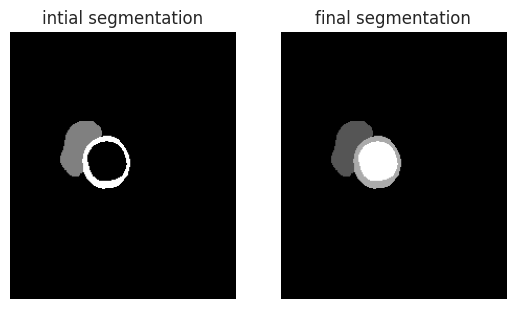

In [ ]:
visualize_seg("101",channel=1)

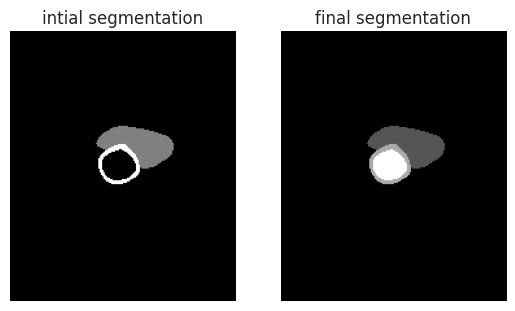

In [ ]:
visualize_seg("102",channel=4)

**Segmentation of the test set**

In [ ]:
#takes a while to run , l a list of lists of images such that the i th element of l represents the segmentations of all the channels of the i-th test data
#the function changes the attribute of the class directy so no need to further store the results
l=[]
L=[]
for i in range(len(test_list)) :
  l1=[]
  for j in range (test_list[i].image_ED_seg[0].shape[2]):
      img=test_list[i].image_ED_seg[0][:,:,j]
      l1.append(fill_region(img))
  l.append(l1)
  l2=[]
  for j in range (test_list[i].image_ES_seg[0].shape[2]):
      img=test_list[i].image_ES_seg[0][:,:,j]
      l2.append(fill_region(img))
  L.append(l1)

## 5.2 Segmentation by transfert learning of a pretrained model Resnet50 (Optional)



* I implemented this part at the beginning to perform image segmentation. Yet, the results were not good enough and the computations were very costly (need for GPU to train and a long computation time). So after all I used the filling method explained before to do the segmentation. And this part I preserved in comments and I did not use it to compute the features.

* If you want to run this code, make sure to reload the data while putting the previous method into comments so the data will not be transformed by the filling algorithm.

* The execution of this part remains optional since it was not used in the next steps.


In [ ]:
print("You can skip this part, the segmentation using the filling method gave better results")

You can skip this part, the segmentation using the filling method gave better results


### 5.2.1 Data preparation for Resnet50

We need to rework the data so that it will be suitable as entry of our CNN. First of all, we will resize all the images to a uniform size. The 256x256 was chosen as is the size for the Resnet pretrained CNNs.

In [ ]:
## Set the number of MRI images and channels
#num_images = 100 
#num_channels = 6 #segmentation of 6 first channels only because come images have just 6 channels and others have till 16

## Initialize an empty NumPy array to store the MRI images
#X = np.zeros((2*num_images, 256, 256, num_channels))
#y = np.zeros((2*num_images, 256, 256, num_channels))
## Loop through each MRI image and load it into the NumPy array
#for i in range(num_images):
#    for j in range(num_channels):
 #       img1=train_list[i].image_ED[0]
#        img2=(train_list[i].image_ED_seg[0])
#        img1/=255
 #       img2/=255
  #      X[i, :, :, j] = np.array(img1[:,:,j])
   #     y[i, :, :, j] = np.array(img2[:,:,j]==3)
   #     img1=train_list[i].image_ES[0]
   #     img2=(train_list[i].image_ES_seg[0])
   #     img1/=255
   #     img2/=255
   #     X[100+i, :, :, j] = np.array(img1[:,:,j])
   #    y[100+i, :, :, j] = np.array(img2[:,:,j]==3)
#print("The shape for X_train = ",X.shape)
#print("The shape for y_train = ",y.shape)

##Resize the data to be considered as 2D images and their masks
#X_resize=np.zeros((2*num_images*num_channels,256,256))
#for i in range(num_images):
#  for j in range (num_channels):
 #   X_resize[i*j,:,:]=X[i,:,:,j]

#y_resize=np.zeros((2*num_images*num_channels,256,256))
#for i in range(num_images):
#  for j in range (num_channels):
#    y_resize[i*j,:,:]=y[i,:,:,j]
#print("X_resize.shape = ",X_resize.shape)

### 5.2.2 Model creation

* The weights are initialized to imagenet model and the architecture of ResNet50V2 is used as backbone.

In [ ]:
##Model creation 
#from tensorflow.keras.applications import ResNet50V2
#from keras.layers import Input
#import tensorflow as tf
#from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D, concatenate
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.optimizers import Adam,SGD,RMSprop
#from keras.callbacks import  EarlyStopping
#from tensorflow.keras.metrics import MeanIoU

#resnet50 = ResNet50V2(weights='imagenet', include_top=False)

#def semantic_segmentation(img_height, img_width, input_channel,lr=0.01):
#  inputs = Input((img_height, img_width, input_channel))
#  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

 # conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
 # drop5 = Dropout(0.5)(conv5)

  #up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  #merge9 = concatenate([conv1,up9], axis = 3)
  #conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

  #conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

  #model = Model(inputs, conv10)

  #model.compile(optimizer=Adam(lr=lr), loss="mse",metrics=["mae"])

  #return(model)

#semantic_segmentation(256, 256, 1).summary()



In [ ]:
## Train the model

#model = semantic_segmentation(256, 256, 1)
#learning_rate = 0.01
#X_train, X_test, Y_train, Y_test = X_resize[:1000,:,:],X_resize[1000:,:,:],y_resize[:1000,:,:],y_resize[1000:,:,:]
#print(X_train.shape)
#print(Y_train.shape)
#n_epochs = 20
#batch_size = 32

#print('Training')
#model.fit(X_train, Y_train, epochs=n_epochs,batch_size=batch_size) 

#print('Testing')
#model.evaluate(X_test, Y_test, verbose=2) 


In [ ]:
#M=model.predict(X_testing_resize)
#plt.imshow(M[50],cmap="gray")
#model.save_weights('SegodelWeights.h5')
##model = model.load_weights('SegModelWeights.h5')

# 6.Feature Extraction 

- One of the challenges of this project is that we only have the images and partial segmentations of the components, unlike in the practical labs, where usually the features were already extracted.

- The first challenge is determining which features might be useful for the classification problem. There was no way to verify that we were extracting the features correctly with no explicit formulas. For that, my goal was to make sure that the information that I am getting from the images makes sense for the diagnostics from a medical point of view and I went further in reading about the classes and their anatomical effects. 

- Also, it was challenging to deal with 3D images and understand the transition between 2D and 3D images, for that some features may use strong assumptions about the shape of the components and the efficiency of the given segmentation. (more details are explained in the report)

**volume_component :**   Calculate the volume of a specific component in a given state for a subject. This is a generative function to be used for each component corresponding to its label.

In [ ]:
def volume_component(Subject,label,state):
  """
  Calculate the volume of a specific component in a given state for a subject.
  This is a generative function to be used for each component corresponding to its label.

  Args:
    Subject: An object representing a subject.
    label (int): The label corresponding to the component of interest in the 
                segmentation masks.
    state (str): The state of the subject for which the volume is being calculated, 
                either "ES" or "ED".

  Returns:
    The volume of the specified component in the given state, in ml.
    
  Raises:
    ValueError: If state is not "ES" or "ED"
  """
  
  if state=="ED":

    ed_volumes = []
    mask_ED=Subject.image_ED_seg[0]
    
    for i in range (mask_ED.shape[-1]):
      mask=mask_ED[:,:,i]
      area=(mask==label)
      ed_volumes.append(area)
    ed_volumes=[(ed_volumes[i]+ed_volumes[i]+np.sqrt(ed_volumes[i]*ed_volumes[i]))/3 for i in range(len(ed_volumes)-1)]
    return((np.sum(ed_volumes) * Subject.v_ED)/(1000* len(ed_volumes))) 

  if state=="ES":
    es_volumes = []
    mask_ES=Subject.image_ES_seg[0]

    for i in range (mask_ES.shape[-1]):
      mask=mask_ES[:,:,i]
      area=(mask==label)
      es_volumes.append(area)
    es_volumes=[(es_volumes[i]+es_volumes[i]+np.sqrt(es_volumes[i]*es_volumes[i]))/3 for i in range(len(es_volumes)-1)]
    return((np.sum(es_volumes) * Subject.v_ES) / (1000*len(es_volumes)))


  print("state should be ES or ED")


In the following functions we will take advantage from the function volume_component to compute the volumes of the right ventricle cavity, left ventricle cavity and myocardium at end diastole and at end systole.

In [ ]:
def volume_right_ventricle_cavity_ED(Subject):
  return(volume_component(Subject,label=1,state="ED"))

def volume_right_ventricle_cavity_ES(Subject):
  return(volume_component(Subject,label=1,state="ES"))

def volume_myocardium_ED(Subject):
  return(volume_component(Subject,label=2,state="ED"))

def volume_myocardium_ES(Subject):
  return(volume_component(Subject,label=2,state="ES"))


def volume_left_ventricle_cavity_ED(Subject):
  if (type(Subject) is Subject_train):
    return(volume_component(Subject,label=3,state="ED"))
  if (type(Subject) is Subject_test):
    vol = volume_component(Subject,label=3,state="ED")
    if vol > 216 * 256 * Subject.v_ED / 2000 :  # Special case bad segmentation volume greater than half the total volume (confusion with background)
      return 
    return(vol)

def volume_left_ventricle_cavity_ES(Subject):
  if (type(Subject) is Subject_train):
    return(volume_component(Subject,label=3,state="ES"))
  if (type(Subject) is Subject_test):
    vol = volume_component(Subject,label=3,state="ES")
    if vol > 216 * 256 * Subject.v_ES / 2000 :  # Special case bad segmentation volume greater than half the total volume (confusion with background)
      return   
    return(vol)

**myocardial_thickness** This function computes the thickness of the cardiac muscle based on the segmentation of the myocardial.

In [ ]:
def myocardial_thickness(Subject,state):
    """
    Computes the mean myocardial thickness for a given subject and state (either "ED" or "ES").
    
    Args:
        Subject: An instance of the Subject class containing information about the subject.
        state (str): The cardiac phase for which to compute the myocardial thickness. Must be either "ED" or "ES".
    
    Returns:
        The mean myocardial thickness for the given subject and state.
    """
    
    mask_ED=Subject.image_ED_seg[0]
    mask_ES=Subject.image_ES_seg[0]


    end_diastole_lv_boundary = find_boundaries(mask_ED, mode='inner')
    end_systole_lv_boundary = find_boundaries(mask_ES, mode='inner')

    # Compute the centroids of the endocardial surfaces
    end_diastole_lv_centroid = ndimage.center_of_mass(end_diastole_lv_boundary)
    end_systole_lv_centroid = ndimage.center_of_mass(end_systole_lv_boundary)

    end_diastole_lv_distance = np.sqrt(np.sum((np.indices(mask_ED.shape) - np.array(end_diastole_lv_centroid)[:, np.newaxis, np.newaxis, np.newaxis]) ** 2,axis=0))
    end_systole_lv_distance = np.sqrt(np.sum((np.indices(mask_ES.shape) - np.array(end_systole_lv_centroid)[:, np.newaxis, np.newaxis, np.newaxis]) ** 2, axis=0))

    # Compute the myocardial thickness as the minimum distance between each voxel in the left ventricle segmentation
    # masks and the endocardial surfaces
    end_diastole_thickness = np.min(end_diastole_lv_distance * mask_ED, axis=(0, 1, 2)).mean()
    end_systole_thickness = np.min(end_systole_lv_distance * mask_ES, axis=(0, 1, 2)).mean()
    if state=="ED":
      myocardial_thickness = np.abs(end_diastole_thickness)
      return myocardial_thickness
    if state=="ES":
      myocardial_thickness = np.abs(end_systole_thickness)
      return myocardial_thickness
    print("state should be ES or ED")

**myocardial_thickness_max** Here we compute the maximum surface among the slices of the myocradial which is theoretically correlated to the thickness.

In [ ]:
def myocardial_thickness_max(Subject,state): # here we compute the maximum surface which is correlated to the thickness
  """
    Computes the maximum myocardial surface in the end diastole or end systole state 
    for a given subject.

    Args:
    - Subject: an instance of the Subject class that contains the segmentation masks
    - state: a string indicating the state of the heart (end diastole or end systole)

    Returns:
    - The maximum myocardial surface in the end diastole or end systole state
  """

  if state=="ED":

    ed_volumes = []
    mask_ED=Subject.image_ED_seg[0]
    
    for i in range (mask_ED.shape[-1]):
      mask=mask_ED[:,:,i]
      area=(mask==2)
      ed_volumes.append(area)
    return((np.max(ed_volumes) * Subject.v_ED)) 

  if state=="ES":
    es_volumes = []
    mask_ES=Subject.image_ES_seg[0]

    for i in range (mask_ES.shape[-1]):
      mask=mask_ES[:,:,i]
      area=(mask==2)
      es_volumes.append(area)
    return((np.max(es_volumes) * Subject.v_ES))


  print("state should be ES or ED")  


**myocardial_thickness_min** Here we compute the minimum surface among the slices of the myocradial which is theoretically correlated to the thickness.

In [ ]:
def myocardial_thickness_min(Subject,state): # here we compute the minimum surface which is correlated to the thickness
  """
    Computes the minimum myocardial surface in the end diastole or end systole state 
    for a given subject.

    Args:
    - Subject: an instance of the Subject class that contains the segmentation masks
    - state: a string indicating the state of the heart (end diastole or end systole)

    Returns:
    - The minimum myocardial surface in the end diastole or end systole state
  """

  if state=="ED":

    ed_volumes = []
    mask_ED=Subject.image_ED_seg[0]
    
    for i in range (mask_ED.shape[-1]):
      mask=mask_ED[:,:,i]
      area=(mask==2)
      ed_volumes.append(area)
    return((np.min(ed_volumes) * Subject.v_ED)) 

  if state=="ES":
    es_volumes = []
    mask_ES=Subject.image_ES_seg[0]

    for i in range (mask_ES.shape[-1]):
      mask=mask_ES[:,:,i]
      area=(mask==2)
      es_volumes.append(area)
    return((np.min(es_volumes) * Subject.v_ES) )


  print("state should be ES or ED")  


**ejection_fractions** Calculates the ejection fraction of the specified ventricle (left or right) for a given subject.

In [ ]:
def ejection_fractions(Subject,ventricle):
  """
    Calculates the ejection fraction of the specified ventricle (left or right) for a given subject.

    Parameters:
    Subject (object): An object containing information about the subject's heart including segmented images and ventricular volumes.
    ventricle (str): A string specifying which ventricle to calculate ejection fraction for. Can be 'left' or 'right'.

    Returns:
    float: The ejection fraction of the specified ventricle, calculated as (end diastolic volume - end systolic volume) / end diastolic volume.
  """
  
  epsilon = 1e-9 #avoid dividing by zero
  if ventricle=="left":
    ed_lv_vol=volume_left_ventricle_cavity_ED(Subject)
    es_lv_vol = volume_left_ventricle_cavity_ES(Subject)
    return ((ed_lv_vol - es_lv_vol) / (ed_lv_vol+epsilon))
  if ventricle=="right":
    ed_lv_vol=volume_right_ventricle_cavity_ED(Subject)
    es_lv_vol = volume_right_ventricle_cavity_ES(Subject)
    return ((ed_lv_vol - es_lv_vol) / (ed_lv_vol+epsilon))

In [ ]:
#test of the functions on a random subject 

idx=0

subject=train_list[idx]

print("volume_left_ventricle_cavity_ED = ",volume_left_ventricle_cavity_ED(subject))
print("volume_left_ventricle_cavity_ES = ",volume_left_ventricle_cavity_ES(subject))
print("volume_right_ventricle_cavity_ED = ",volume_right_ventricle_cavity_ED(subject))
print("volume_myocardium_ED = ",volume_myocardium_ED(subject))
print("volume_myocardium_ES = ",volume_myocardium_ES(subject))
print("myocardial_thickness_ES = ",myocardial_thickness(subject,"ES"))
print("myocardial_thickness_ED = ",myocardial_thickness(subject,"ED"))
print("myocardial_thickness_max = ",myocardial_thickness_max(subject,"ES"))
print("myocardial_thickness_min = ",myocardial_thickness_min(subject,"ES"))
print("ejection_fractions = ",ejection_fractions(subject,"right"))

volume_left_ventricle_cavity_ED =  22.764756944444443
volume_left_ventricle_cavity_ES =  17.220052083333332
volume_right_ventricle_cavity_ED =  9.814453125
volume_myocardium_ED =  8.702256944444445
volume_myocardium_ES =  11.338975694444445
myocardial_thickness_ES =  8.587037476381216
myocardial_thickness_ED =  10.286128001575555
myocardial_thickness_max =  24.414062
myocardial_thickness_min =  0.0
ejection_fractions =  0.6218905472003168


In [ ]:
def featureExtractions_train(subject_train):
  """
    This function extracts features from a given training subject.

    Args:
    subject_train: The training subject from which the features will be extracted.

    Returns:
    A list of extracted features.
  """
  if (subject_train):
    features = []
    features.append(subject.id)
    features.append(subject.height[0])
    features.append(subject.weight[0])
    features.append(volume_left_ventricle_cavity_ED(subject))
    features.append(volume_left_ventricle_cavity_ES(subject))
    features.append(volume_right_ventricle_cavity_ED(subject))
    features.append(volume_right_ventricle_cavity_ES(subject))
    features.append(volume_myocardium_ED(subject))
    features.append(volume_myocardium_ES(subject))
    features.append(myocardial_thickness_max(subject,"ES"))
    features.append(myocardial_thickness_min(subject,"ES"))
    features.append(myocardial_thickness_max(subject,"ED"))
    features.append(myocardial_thickness_min(subject,"ED"))
    features.append(ejection_fractions(subject,"right"))
    features.append(ejection_fractions(subject,"left"))
    features.append(subject.label)
    return features

In [ ]:
def featureExtractions_test(subject_test):
  """
    This function extracts features from a given test subject.

    Args:
    subject_test: The training subject from which the features will be extracted.

    Returns:
    A list of extracted features.
  """
  if (subject_test):
    features = []
    features.append(subject.id)
    features.append(subject.height[0])
    features.append(subject.weight[0])
    features.append(volume_left_ventricle_cavity_ED(subject))
    features.append(volume_left_ventricle_cavity_ES(subject))
    features.append(volume_right_ventricle_cavity_ED(subject))
    features.append(volume_right_ventricle_cavity_ES(subject))
    features.append(volume_myocardium_ED(subject))
    features.append(volume_myocardium_ES(subject))
    features.append(myocardial_thickness_max(subject,"ES"))
    features.append(myocardial_thickness_min(subject,"ES"))
    features.append(myocardial_thickness_max(subject,"ED"))
    features.append(myocardial_thickness_min(subject,"ED"))
    features.append(ejection_fractions(subject,"right"))
    features.append(ejection_fractions(subject,"left"))
    return features

In [ ]:
#Compute the features and store them into csv files for train and test

feature_names_test = ["Id","Height","Weight","volume_left_ventricle_cavity_ED","volume_left_ventricle_cavity_ES","volume_right_ventricle_cavity_ED","volume_right_ventricle_cavity_ES","volume_myocardium_ED","volume_myocardium_ES","myocardial_thickness_ES_max","myocardial_thickness_ES_min","myocardial_thickness_ED_max","myocardial_thickness_ED_min","ejection_fractions_right","ejection_fractions_left"]
feature_names_train = feature_names_test + ["label"]

features_train=[]
for subject in train_list:
  features_train.append(featureExtractions_train(subject))
pd_train_features = pd.DataFrame(features_train, columns= feature_names_train)
pd_train_features.to_csv('training.csv', index= False)
files.download('training.csv')

features_test=[]
for subject in test_list:
  features_test.append(featureExtractions_test(subject))

pd_test_features = pd.DataFrame(features_test, columns= feature_names_test)
pd_test_features.to_csv('test.csv', index= False)
files.download('test.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* Extracting the features was more challenging than I expected. Although a list of features was provided in the description of the challenge and in some papers, there was no information there on how to exactly compute them.

* I searched for methods in multiple resources, and I made some assumptions about the data to bypass some problems. Even with that, there were some references pointing out different formulas over the same feature that are not the same (maybe correlated values).

* There were some issues with myocardial_thickness_min and myocardial_thickness when dealing with the test segmentations, for that, I decided not to consider them in the classification so they don't fool the models.

* I tried to implement other kinds of features like anomalies that could happen to the myocardial (useful to class the class "1" myocardial infarction)[[see image on page 9 of this document](https://fcsante.univ-angers.fr/_resource/Cours%2520en%2520ligne/DIU%2520Imagerie%2520cardiaque%2520et%2520vasculaire/UV3%2520LYON%25202020/Si-Mohamed-Isch%25C3%25A9mie%2520myocardique%2520et%2520infarctus%2520en%2520scanner.pdf) ]. However, the implementation for these functions was very complex and they are based on Deep learning techniques to extract these kinds of features.


# 7.Methods over extracted features



### 7.1. Data preparation

In [ ]:
#loading the data
data = pd.read_csv('training.csv')
data.head()


,Id,Height,Weight,volume_left_ventricle_cavity_ED,volume_left_ventricle_cavity_ES,volume_right_ventricle_cavity_ED,volume_right_ventricle_cavity_ES,volume_myocardium_ED,volume_myocardium_ES,myocardial_thickness_ES_max,myocardial_thickness_ES_min,myocardial_thickness_ED_max,myocardial_thickness_ED_min,ejection_fractions_right,ejection_fractions_left,label
0,1,184.0,95.0,22.764757,17.220052,9.814453,3.710938,8.702257,11.338976,24.414062,0.0,24.414062,0.0,0.621891,0.243565,2
1,2,160.0,70.0,19.639078,13.890245,6.263902,1.499515,8.428023,11.613973,18.692017,0.0,18.692017,0.0,0.760610,0.292724,2
2,3,165.0,77.0,20.258247,17.708333,14.236111,12.923177,13.639323,14.333767,24.414062,0.0,24.414062,0.0,0.092226,0.125870,2
3,4,159.0,46.0,19.290161,16.656663,6.940969,5.121612,9.271240,9.844462,18.692017,0.0,18.692017,0.0,0.262119,0.136520,2
4,5,165.0,77.0,22.869141,17.428712,12.304688,4.987793,12.216797,15.363281,19.775390,0.0,19.775390,0.0,0.594643,0.237894,2


In [ ]:
#drop myocardial_thickness_ED_min since it hasn't give good results because of the segmentation of some slices
data = data.drop(['Id',"myocardial_thickness_ED_min","myocardial_thickness_ES_min"], axis = 1).copy() 

#Seperate the features and the labels
y = data["label"]
X = data.drop(["label"], axis=1, inplace=False)


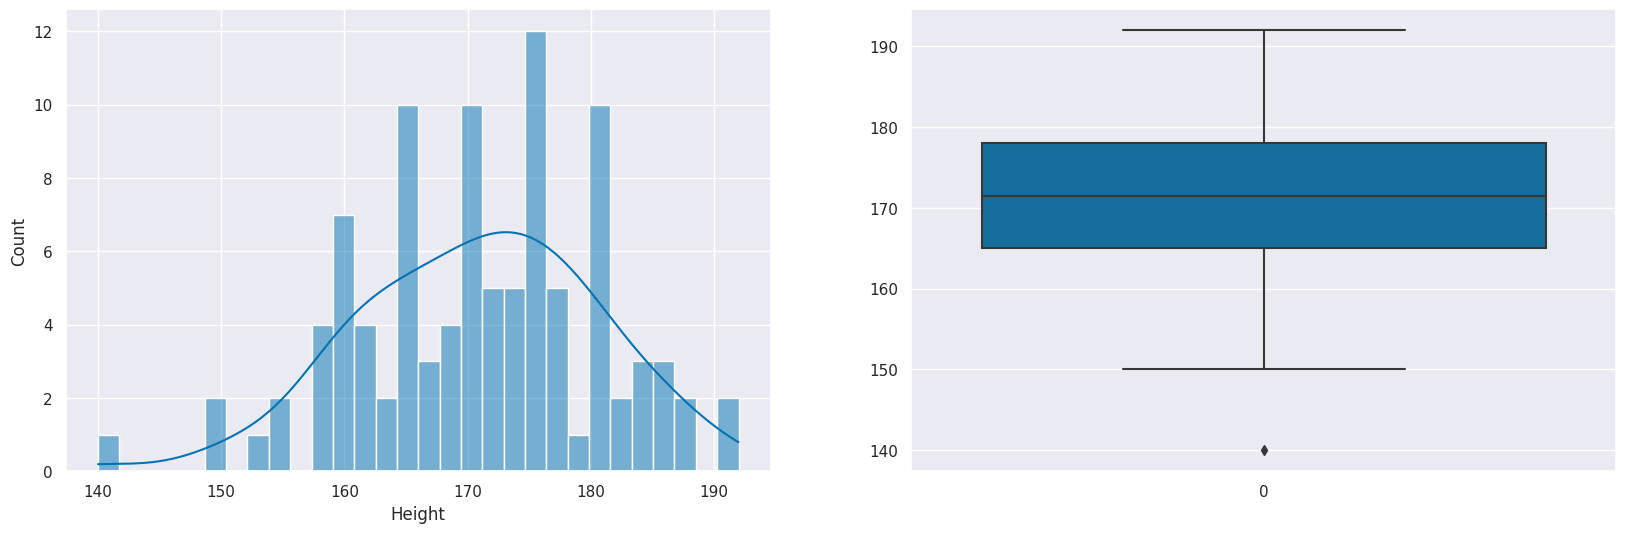

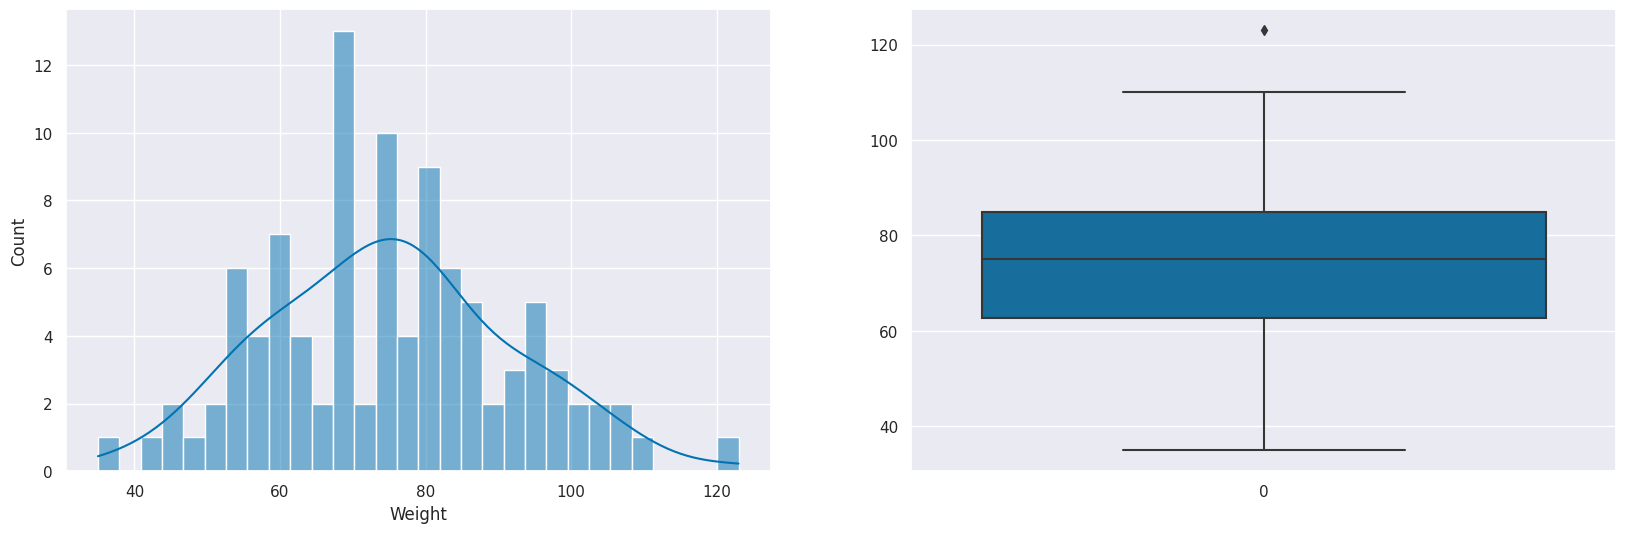

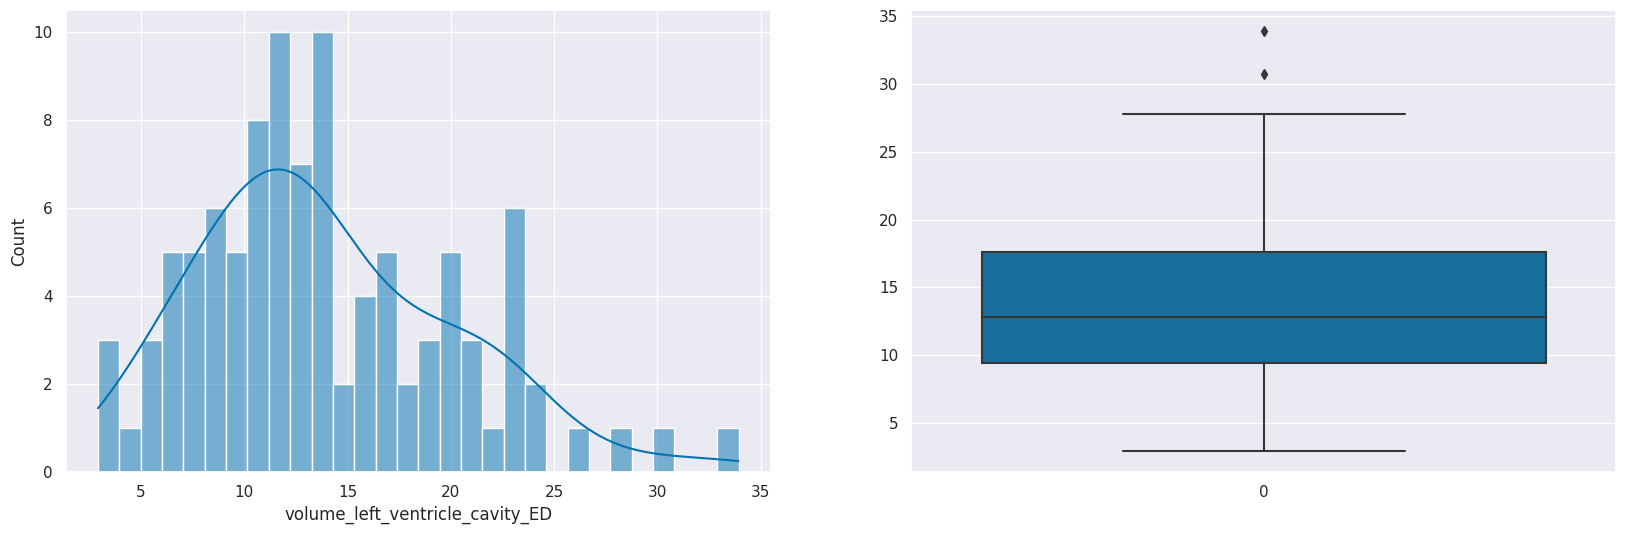

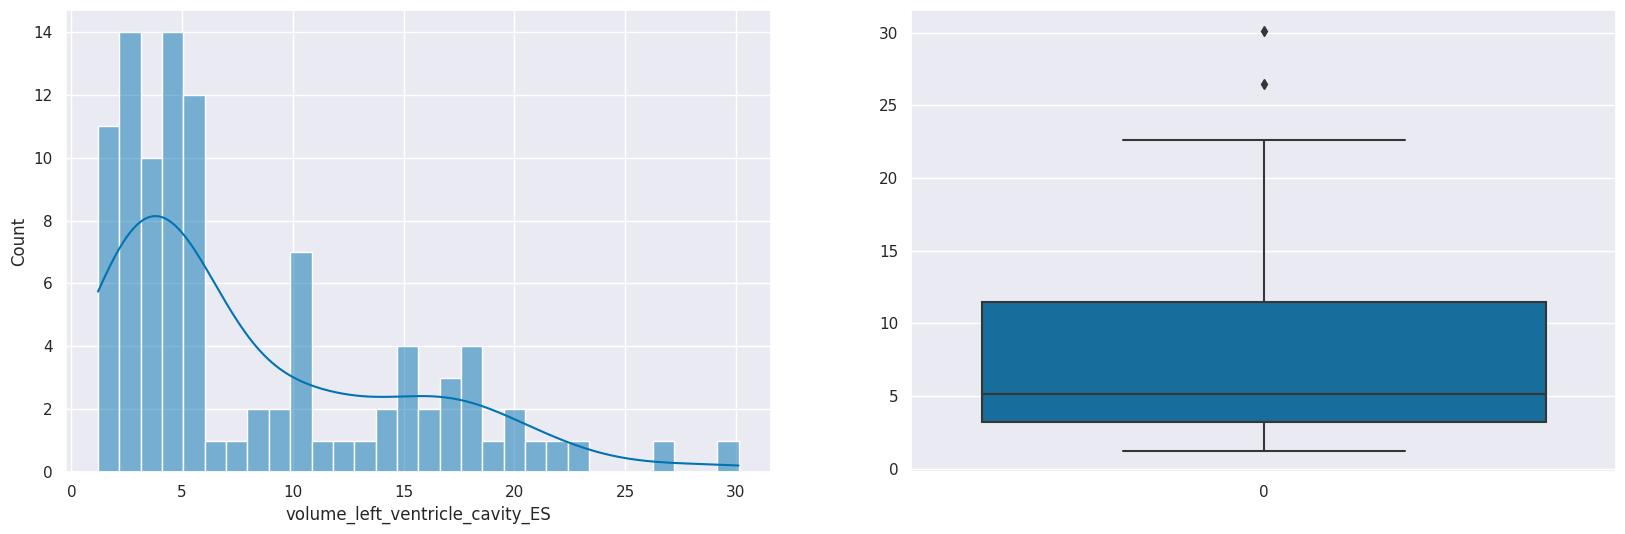

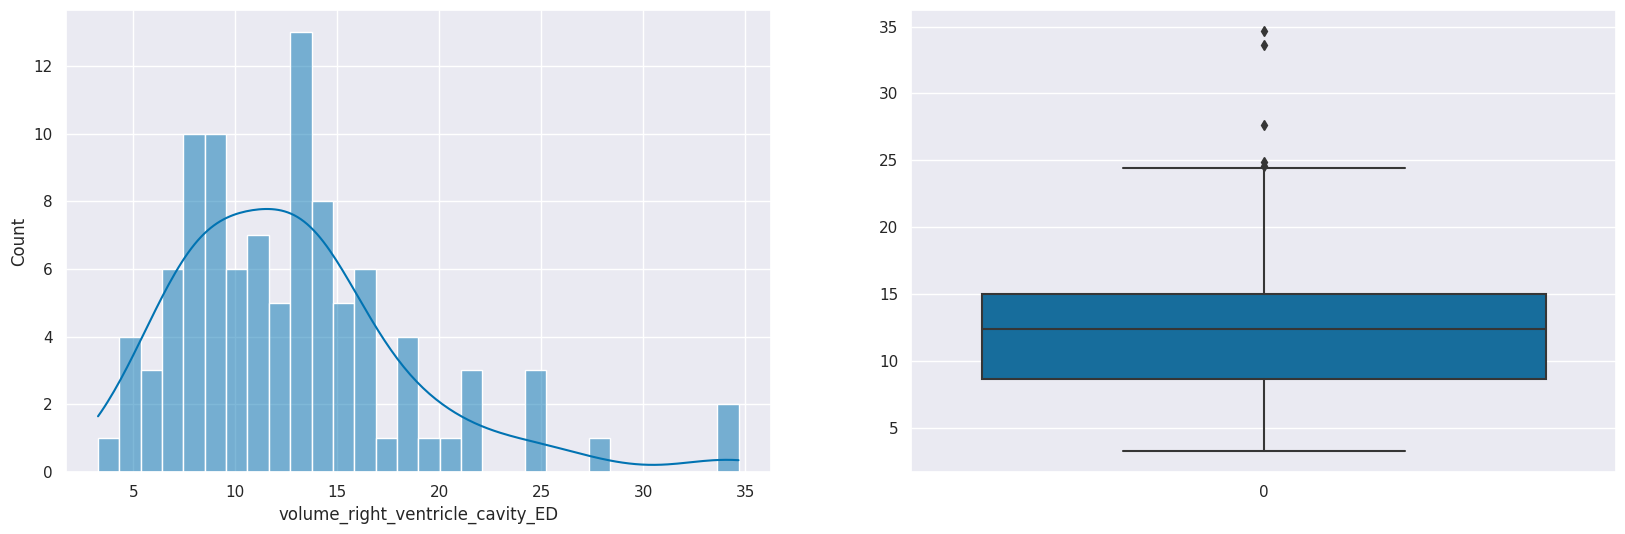

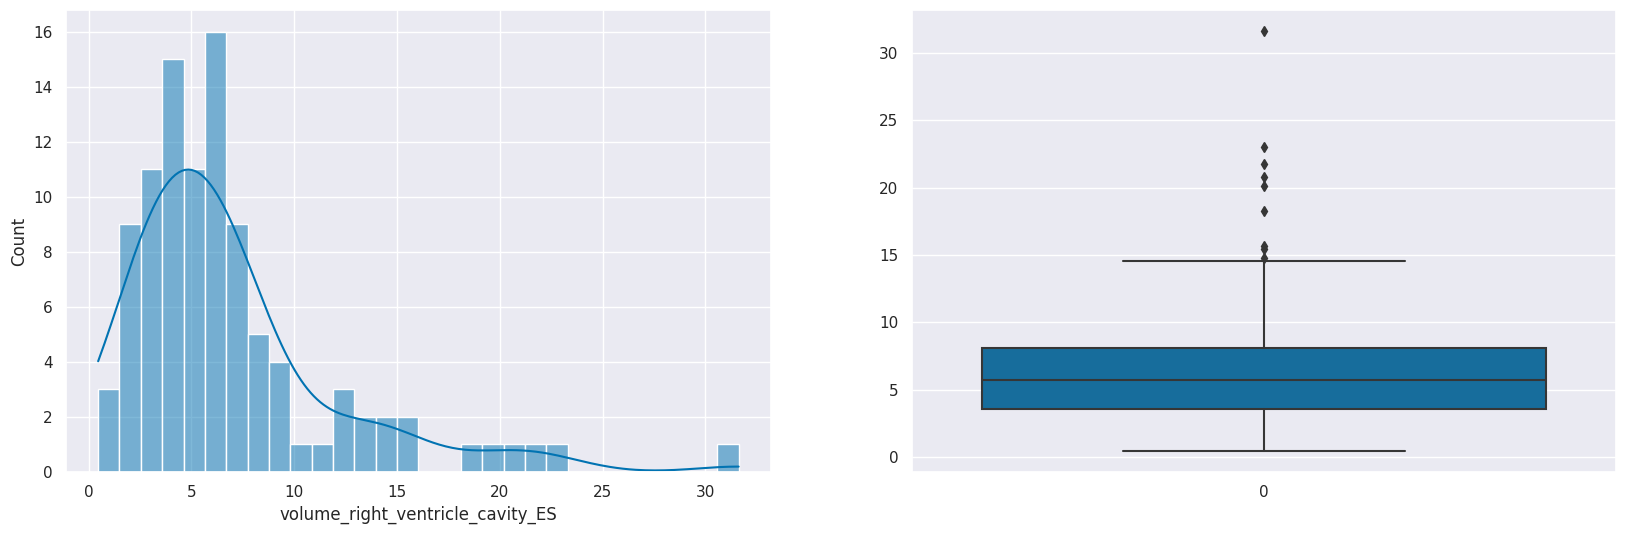

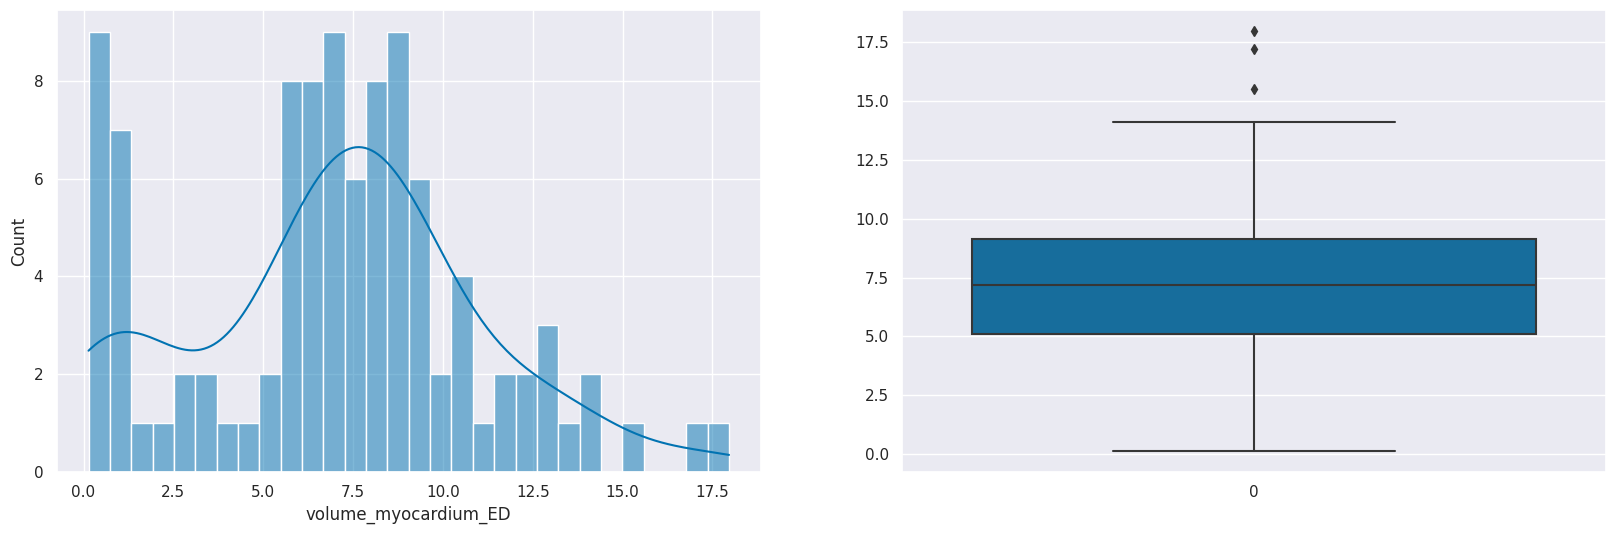

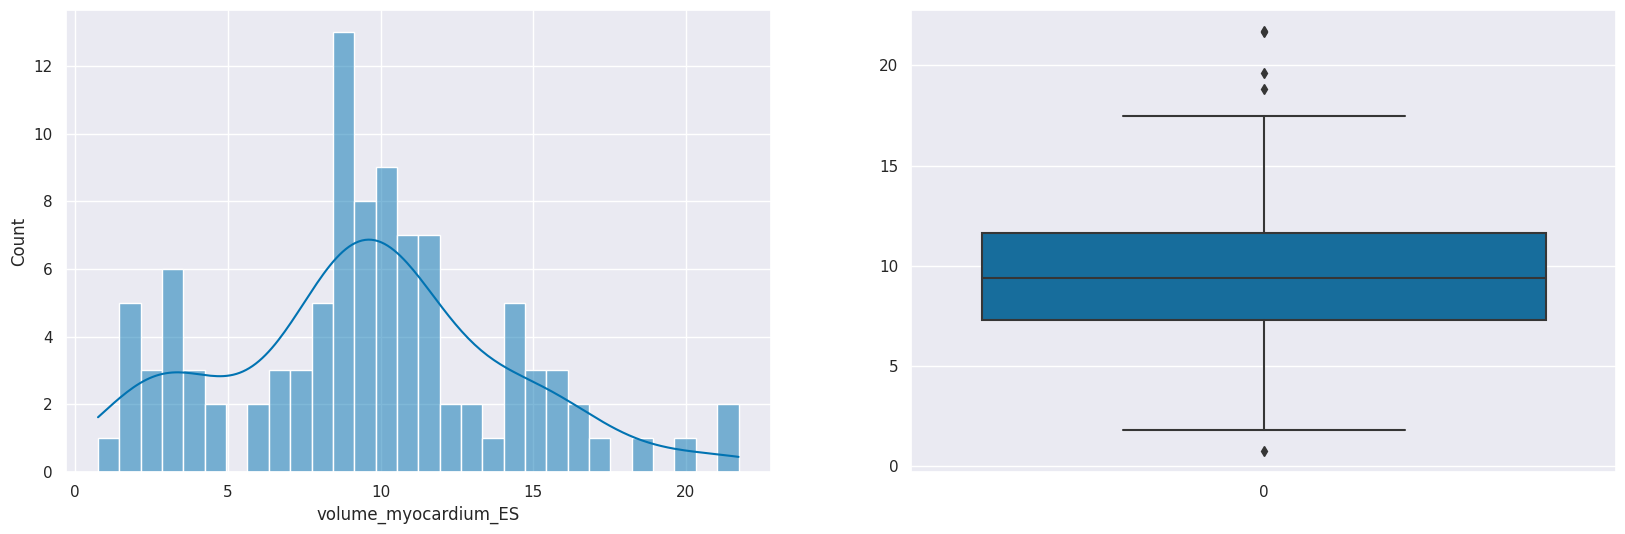

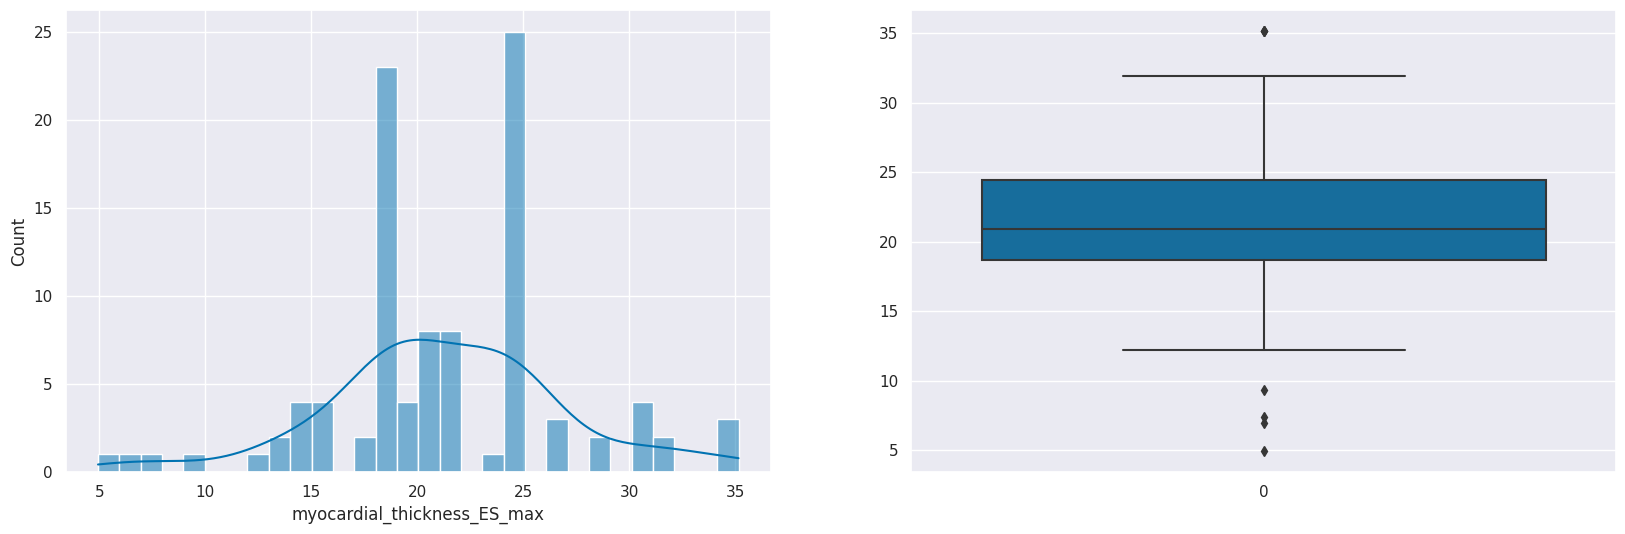

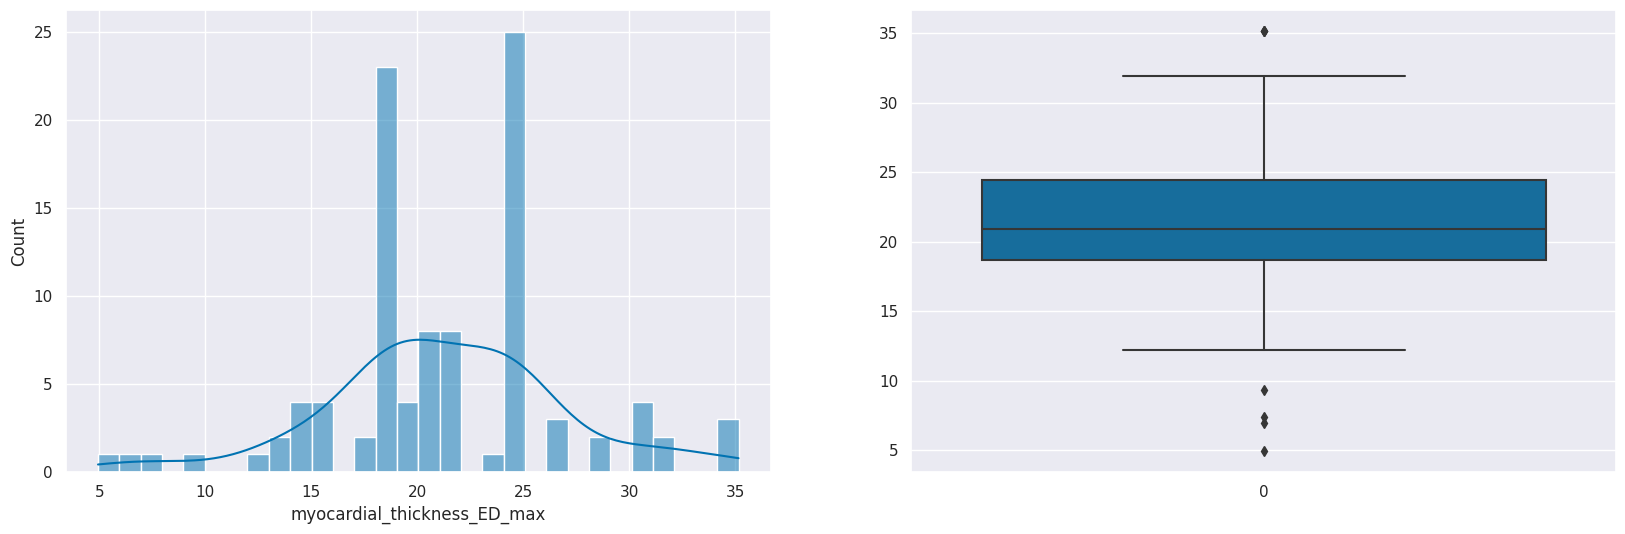

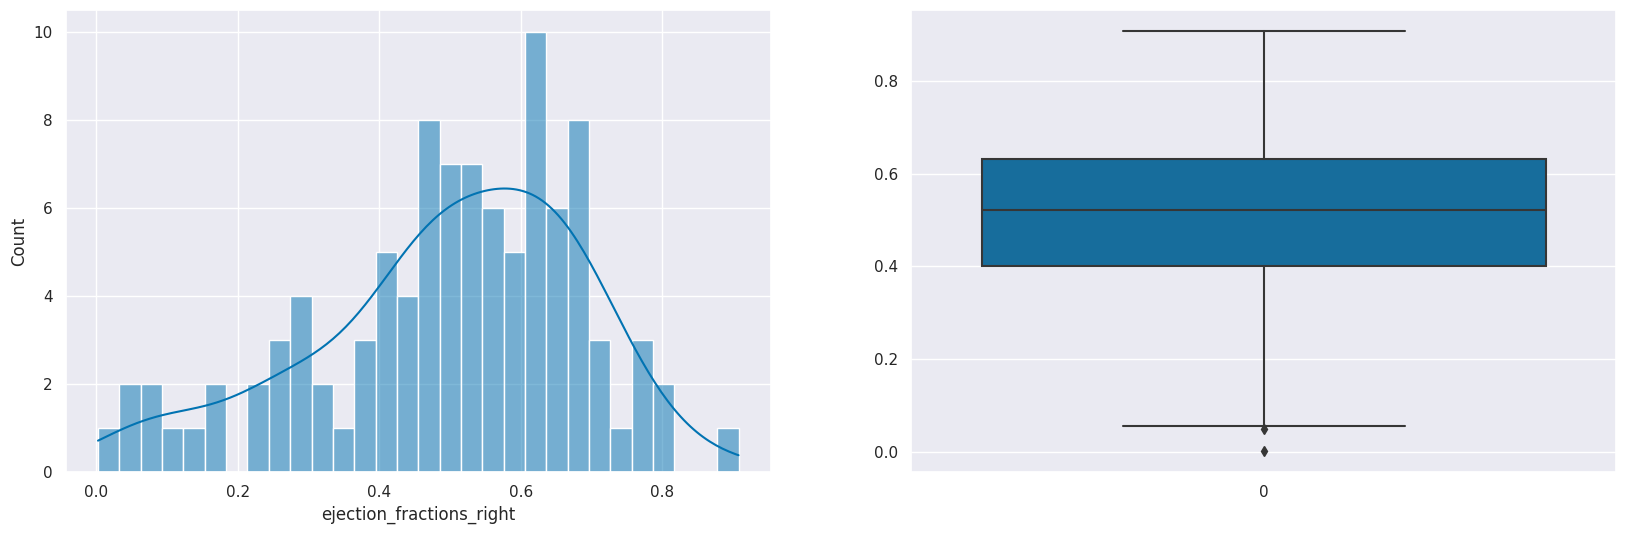

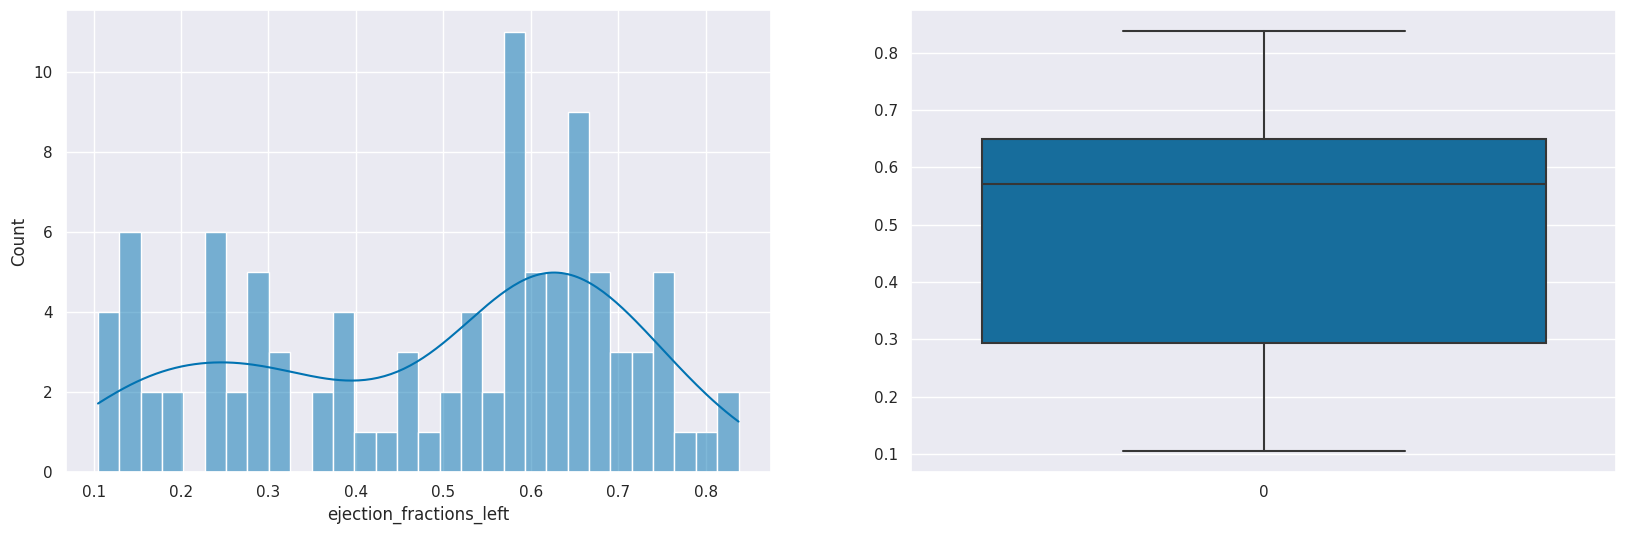

In [ ]:
names = data.columns[:-1]
for name in names:
  distbox(data,name)

<blockquote>

The quality of the different extracted features seems to be good, having some "cool" distributions with some outliers that don't have extreme effects. Some outliers exist for volume_right_ventricle_ED and volume_right_ventricle_ES, but they are not very strange. We can say that the data doesn't need a complete preprocessing for data balance, imputations, and normalization. I decided that is sufficient in this case to scale the data and split it into training and validation parts.

In [ ]:
Xp=X
yp=y

X_train, X_val, y_train, y_val = train_test_split(Xp, yp, test_size=0.2, random_state=46,stratify=yp)

print("the length of y_train is", len(y_train))
print("the length of y_test is", len(y_val))
print("the shape of X_train is", X_train.shape)
print("the Shape of X_test is", X_val.shape)


the length of y_train is 80
the length of y_test is 20
the shape of X_train is (80, 12)
the Shape of X_test is (20, 12)


In [ ]:

print("the length of y_train is", len(y_train))
print("the length of y_test is", len(y_val))
print("the shape of X_train is", X_train.shape)
print("the Shape of X_test is", X_val.shape)


the length of y_train is 80
the length of y_test is 20
the shape of X_train is (80, 12)
the Shape of X_test is (20, 12)


In [ ]:

# standardizing the data

scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train) 
X_val = scale.transform(X_val)


## 7.2. Classification Models

### 7.2.1 Decision Trees

In [ ]:

Tree = DecisionTreeClassifier(random_state=0)

Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )

p_grid_Tree = {'min_samples_leaf': [2,3,4,5,6]}   
grid_Tree = GridSearchCV(estimator=Tree, param_grid=p_grid_Tree, scoring='accuracy', cv=5)
grid_Tree.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_Tree.best_score_))
print("Best params: {}".format(grid_Tree.best_params_))
print("Tree mean score :",grid_Tree.score(X_val,y_val))

Score in the training set is 1.0
Best Validation Score: 0.7875
Best params: {'min_samples_leaf': 2}
Tree mean score : 0.85


In [ ]:
Tree = DecisionTreeClassifier(random_state=0,min_samples_leaf=2)
Tree.fit(X_train,y_train)
y_pred_tree = Tree.predict(X_val)
print(classification_report(y_val, y_pred_tree))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.75      0.75      0.75         4
           2       0.75      0.75      0.75         4
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         4

    accuracy                           0.85        20
   macro avg       0.86      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



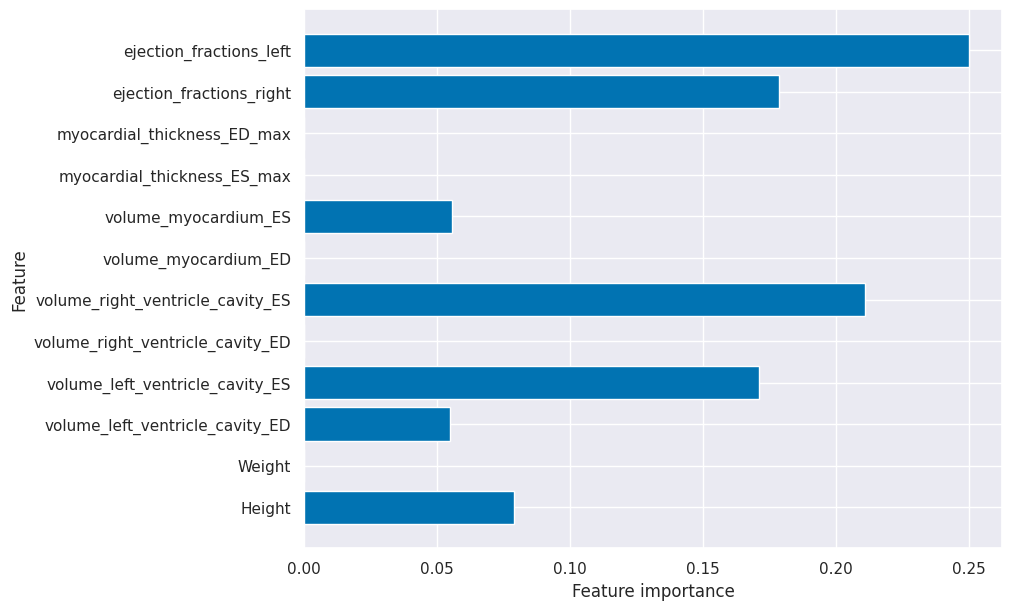

In [ ]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), Tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), Xp.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

plt.show()

### 7.2.2 Random Forest

In [ ]:

RF=RandomForestClassifier(random_state=0)
RF.fit(X_train,y_train)
print('Score in the training set is {0}'.format(RF.score(X_train,y_train)) )

p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest mean score :",grid_RF.score(X_val,y_val))




Score in the training set is 1.0
Best Validation Score: 0.8625
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest mean score : 0.85


In [ ]:
RF = RandomForestClassifier(random_state=0,min_samples_leaf=5,n_estimators=15,max_features='sqrt')
RF.fit(X_train,y_train)
y_pred_RF = RF.predict(X_val)
print(classification_report(y_val, y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         4
           3       0.75      0.75      0.75         4
           4       0.75      0.75      0.75         4

    accuracy                           0.85        20
   macro avg       0.86      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



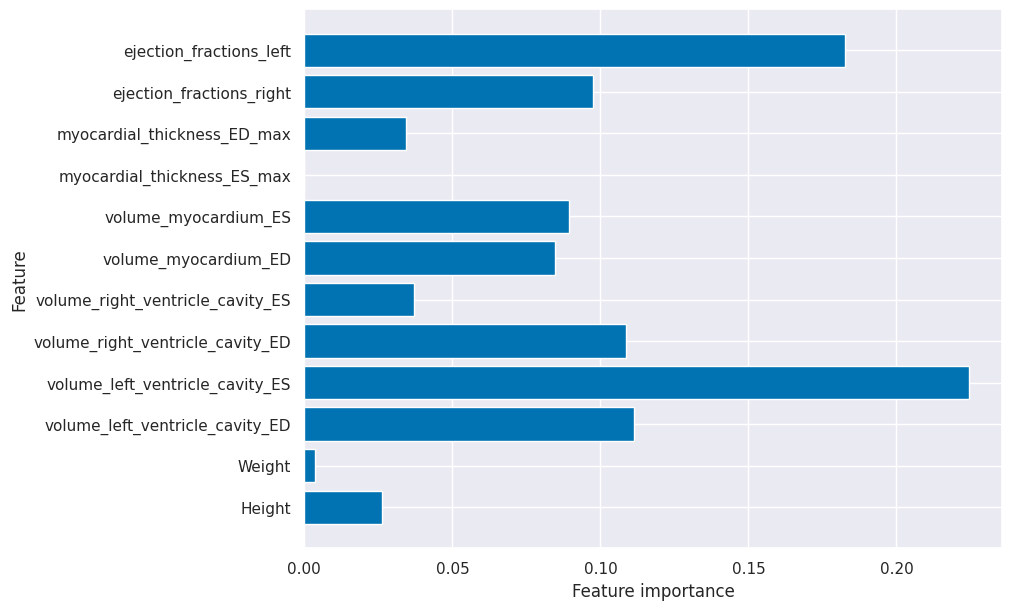

In [ ]:
plt.figure(figsize=(9,7))
n = X_train.shape[1]
plt.barh(range(n), RF.feature_importances_, align='center')
plt.yticks(np.arange(n), Xp.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### 7.2.3 KNN classifier

In [ ]:
#Create the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)


p_grid_knn = {'n_neighbors': [i for i in range(1,20)]}   

grid_KNN = GridSearchCV(estimator=knn_model, param_grid=p_grid_knn, scoring='accuracy', cv=5)
grid_KNN.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_KNN.best_score_))
print("Best params: {}".format(grid_KNN.best_params_))
print("Knn mean score :",grid_KNN.score(X_val,y_val))


Best Validation Score: 0.85
Best params: {'n_neighbors': 7}
Knn mean score : 0.85


In [ ]:
#Train the model using the training sets
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn_model.predict(X_val)

print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.80      1.00      0.89         4
           2       0.75      0.75      0.75         4
           3       1.00      0.75      0.86         4
           4       0.75      0.75      0.75         4

    accuracy                           0.85        20
   macro avg       0.86      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



### 7.2.4 MLP classifier

In [ ]:
model_mlp = MLPClassifier()

parameters = {
    'solver': ['lbfgs', 'adam'],
    'max_iter': [1000,2000,3000,4000,5000],
    'alpha': 10.0 ** -np.arange(1, 5),
    'hidden_layer_sizes': [10,50,100,250,500],
    'random_state':[0,4] }

search = RandomizedSearchCV(model_mlp, param_distributions=parameters, random_state=42, n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model with rank: 1
Mean validation score: 0.864 (std: 0.075)
Parameters: {'solver': 'lbfgs', 'random_state': 0, 'max_iter': 4000, 'hidden_layer_sizes': 250, 'alpha': 0.01}

Model with rank: 1
Mean validation score: 0.864 (std: 0.075)
Parameters: {'solver': 'lbfgs', 'random_state': 0, 'max_iter': 5000, 'hidden_layer_sizes': 250, 'alpha': 0.01}



In [ ]:
model_mlp = MLPClassifier(solver='lbfgs', random_state= 0 ,max_iter= 1000, hidden_layer_sizes=(500),activation='relu',alpha=0.01)

# fit the model 
model_mlp.fit(X_train, y_train)

#predicting the target value from the model for the samples
y_pred_mlp = model_mlp.predict(X_val)
print(classification_report(y_val, y_pred_mlp))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.75      0.75      0.75         4
           2       0.60      0.75      0.67         4
           3       1.00      1.00      1.00         4
           4       1.00      0.75      0.86         4

    accuracy                           0.85        20
   macro avg       0.87      0.85      0.85        20
weighted avg       0.87      0.85      0.85        20



In [ ]:
model_mlp = MLPClassifier(solver='adam', random_state= 3,max_iter= 2000, hidden_layer_sizes=(100),activation='relu',alpha=0.00001)

# fit the model 
model_mlp.fit(X_train, y_train)

#predicting the target value from the model for the samples
y_pred_mlp = model_mlp.predict(X_val)
print(classification_report(y_val, y_pred_mlp))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.60      0.75      0.67         4
           2       0.67      0.50      0.57         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



### 7.2.5 Support Vector Machines

In [ ]:
#Create a linear SVC Classifier
classifier = SVC(kernel = 'linear', random_state = 0)
classifier = SVC()
param_cv = {'C': [0.1,1, 10], 'gamma': [0.1,0.01,0.001],'kernel': ['linear','poly','rbf']}


search = RandomizedSearchCV(classifier, param_distributions=param_cv, random_state=42, n_iter=500, cv=3, verbose=1, n_jobs=1, return_train_score=True)
search.fit(X, y)
report_best_scores(search.cv_results_, 1)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=500. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 0.1}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 0.1}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.1, 'C': 1}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 1}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 1}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.1, 'C': 10}

Model with rank: 1
Mean validation score: 0.870 (std: 0.028)
Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 10}

Model with rank: 1
Mean validation score: 0.870 (

In [ ]:
classifier = SVC(kernel='linear',gamma=0.1,C=1)
#Train the model using the training sets
classifier.fit(X_train, y_train)

#Prediction sur le Test set
y_pred = classifier.predict(X_val)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.75      0.75      0.75         4
           2       0.75      0.75      0.75         4
           3       1.00      1.00      1.00         4
           4       1.00      0.75      0.86         4

    accuracy                           0.85        20
   macro avg       0.86      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



In [ ]:
classifier = SVC(kernel='linear',gamma=0.001,C=10)
#Train the model using the training sets
classifier.fit(X_train, y_train)

#Prediction sur le Test set
y_pred = classifier.predict(X_val)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.67      1.00      0.80         4
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00         4
           4       1.00      0.75      0.86         4

    accuracy                           0.85        20
   macro avg       0.89      0.85      0.84        20
weighted avg       0.89      0.85      0.84        20



## 7.3. Apply the models on the test data

In [ ]:
#Load test data
data_test = pd.read_csv('test.csv')
data_test=data_test.drop(['Id',"myocardial_thickness_ED_min","myocardial_thickness_ES_min"], axis = 1).copy() 
data_test.head()


,Height,Weight,volume_left_ventricle_cavity_ED,volume_left_ventricle_cavity_ES,volume_right_ventricle_cavity_ED,volume_right_ventricle_cavity_ES,volume_myocardium_ED,volume_myocardium_ES,myocardial_thickness_ES_max,myocardial_thickness_ED_max,ejection_fractions_right,ejection_fractions_left
0,167.0,89.0,23.542825,16.759908,14.032385,8.505563,12.249925,12.261888,26.916340,26.916340,0.393862,0.288110
1,137.0,35.0,5.677992,2.501110,14.278036,8.554741,2.971130,3.173107,14.157228,14.157228,0.400846,0.559508
2,167.0,116.0,11.914062,4.031372,17.980957,9.912109,10.113525,11.944580,24.414062,24.414062,0.448744,0.661629
3,160.0,98.0,11.364788,2.161606,17.047182,6.713129,12.197921,14.675958,18.692085,18.692085,0.606203,0.809798
4,174.0,64.0,7.242838,2.992838,14.802798,11.218188,5.379747,6.365090,14.157228,14.157228,0.242158,0.586787


In [ ]:
#data normalization
X_test = scale.transform(data_test)

In [ ]:
submission = list(model_mlp.predict(X_test)) #in the case of model MLP
print(submission)

##Submission for kaggle
#pd_test_features = pd.DataFrame(submission,columns=["Category"])
#pd_test_features.to_csv('submission.csv', index= False)
#files.download('submission.csv')


[2, 4, 0, 3, 4, 2, 0, 0, 0, 4, 3, 3, 4, 0, 3, 4, 2, 3, 2, 0, 4, 0, 0, 3, 0, 2, 2, 4, 2, 4, 2, 4, 3, 2, 0, 3, 1, 3, 2, 4, 2, 2, 2, 2, 4, 2, 0, 2, 2, 1]


In [ ]:
print("Final Results ")
print(" ")

data = {'Model': ['Decision Trees', 'Random Forest', 'KNN', 'SVC', 'MLP'],
        'Validation Score': [0.7875, 0.8625, 0.85, 0.87, 0.864],
        'Accuracy on private leaderboard (Kaggle)': [0.6571, 0.8, 0.7142, 0.8, 0.8285],
        'Optimal hyperparameters': ["min samples leaf: 2,\ncriterion: gini",
                                    "n estimators: 30,\nmax features: 'sqrt',\nmin_samples_leaf: 4,\ncriterion: entropy",
                                    "K=7",
                                    "kernel: linear,\ngamma: 0.01,\nC: 10",
                                    "solver: lbfgs,\nrandom state: 0,\nhidden layer sizes: 250,\nalpha: 0.01"]}

df = pd.DataFrame(data)

print(df.to_markdown(index=False))

Final Results 
 
| Model          |   Validation Score |   Accuracy on private leaderboard (Kaggle) | Optimal hyperparameters   |
|:---------------|-------------------:|-------------------------------------------:|:--------------------------|
| Decision Trees |             0.7875 |                                     0.6571 | min samples leaf: 2,      |
|                |                    |                                            | criterion: gini           |
| Random Forest  |             0.8625 |                                     0.8    | n estimators: 30,         |
|                |                    |                                            | max features: 'sqrt',     |
|                |                    |                                            | min_samples_leaf: 4,      |
|                |                    |                                            | criterion: entropy        |
| KNN            |             0.85   |                                     0.7

# 8. Conclusion

This project was a good experience in exploring every aspect of a Machine Learning pipeline in medical imaging. The pipeline involved gaining an understanding of the problem and the characteristics of 3D MRI images, preprocessing the data, and segmenting the left ventricle cavity using two different methods. Significant features were extracted based on medical sources and research papers before implementing and optimizing various models to achieve the final results.

Several challenges were faced, including selecting appropriate features and simplified formulas. The unexact extraction of certain features, such as the thickness of the cardiac muscle, led to classification difficulties in the Myocardial infarction category, a significant constraint in our implementation affecting the classifiers' performance.

In the future, better results could be achieved by having more features and a larger dataset of subjects. Furthermore, image segmentation could be improved using state-of-the-art computer vision methods such as the Unet architecture.

# 9. References:

 [1] Cardiac remodeling--concepts and clinical implications: a consensus paper from an international forum on cardiac remodeling. Behalf of an International Forum on Cardiac Remodeling DOI: 10.1016/s0735-1097(99)00630-
 
 [2] Estimation of the volume of the left ventricle from mri
images using deep neural networks.Chen X. Hu X. Song S. Liao, F.  IEEE Transactions on Cybernetics, 49(2), 495–504

[3] Cardiac remodeling concepts and clinical implications: A consensus paper from an international forum on cardiac remodeling. Ferrari R. Sharpe N. Cohn, J. N. Journal of the American College of Cardiology.

[4] Automatic cardiac disease assessment on cine-mri via time-series segmentation and domain specific features. Peter M. Full Ivo Wolf Sandy Engelhardt Klaus H. Maier-Hein Fabian Isensee, Paul Jaeger.